# Введение

На предприятии имеется система ***планирования загрузки***. Один из показателей - загрузка линии по производству панелей, наполненных теплоизозвуколиющим материалом. Линия представляет собой цепь станков, завязанных программно, выполняющих поочередно функции вырубки из листа деталей и гибки.

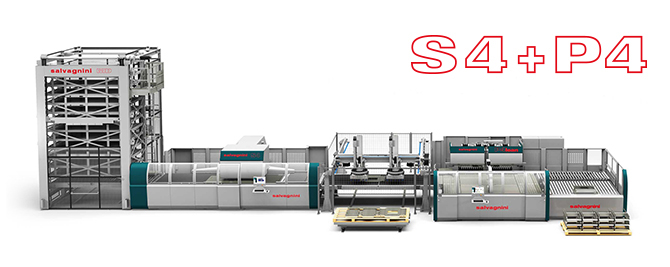

Загрузка линии определяется кратно ***времени*** вырубки деталей.

Из исходных данных имеются:
* Набор файлов job-листов (настроечных файлов), в которых есть наименование датели, ниаменование заказа и время физического изготовления детали - формат xml;
* Набор файлов исходных данных о параметрах деталей для производства панелей - формат xml

# Цель

* Из данных выделить целевые показатели и признаки для проектирования модели. 
* Построить модель предсказывающую время изготовления детали.
* Создать сервис для оценки времени загрузки линии по файлу, описывающему заказ.
* Интегрировать модель в информационную структуру предприятия.

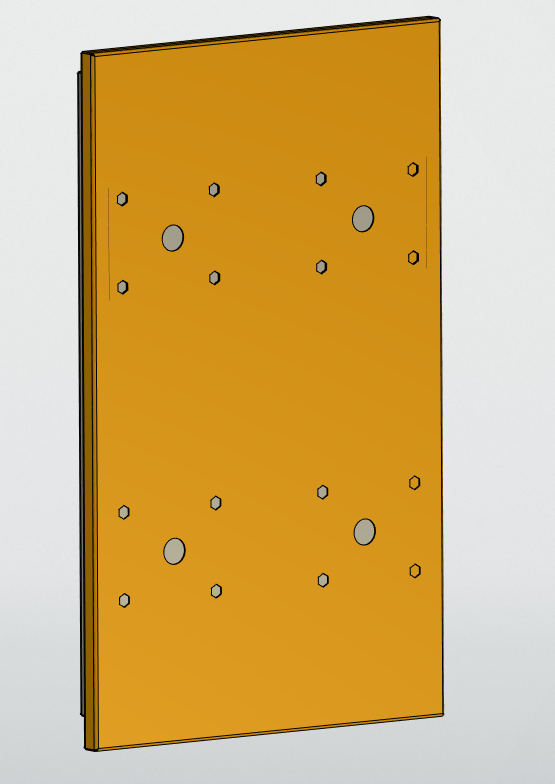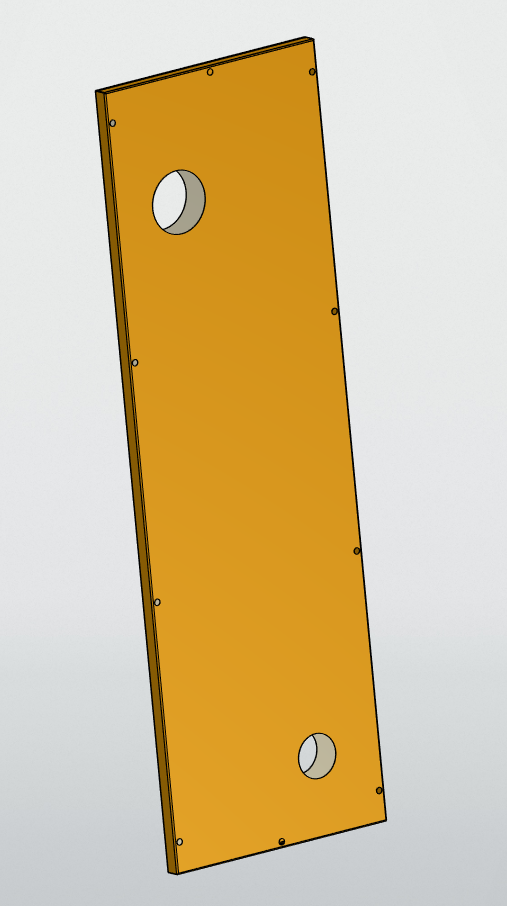

# Импорт библиотек и настройка среды

In [522]:
import ast
import pandas as pd
from pathlib import Path
import xml.etree.ElementTree as ET
from tqdm import tqdm
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.feature_extraction.text import HashingVectorizer
from transliterate import translit
from scipy.stats import normaltest
from catboost import CatBoostRegressor
import plotly_express as px
import pickle
import optuna


pd.set_option('display.max_columns', None)

sns.set(rc={'figure.figsize':(20,10)})
tqdm.pandas()

In [523]:
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    """Функция для очитки данных от выброса по z-отклонениям.
    Делит данные на очищенные и отброшенные. Возвращает два датафрейма.
    Сначала отброшенные. потом очищенные.

    Args:
        data (pd.DataFrame): исходный DataFrame для очистки
        feature (string): признак DataFrame, по которому требуется очистка
        left (int, optional): доверительный интервал слева. Defaults to 3.
        right (int, optional): доверительный интервал справа. Defaults to 3.
        log_scale (bool, optional): флажок для перевода в логарифмическое представление данных. Defaults to False.

    Returns:
        pd.DataFrame, pd.DataFrame: отброшенные данные и очищенные данные соответственно
    """
    
    if log_scale:
        x = np.log(data[feature]+1)
        
    else:
        x = data[feature]
        
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned

# Сбор данных

## Обработка файлов job-листов

Подгрузим один файл, посмотрим на его структуру и выделим то, что нам неоходимо из него забрать.

In [524]:
xml_root = ET.parse('JOB_Rep_JOB_STATUS_20221101090129_100007.xml').getroot()

In [676]:
type(xml_root[0][0])

xml.etree.ElementTree.Element

In [525]:
def recur_print(root, level=0, print_attrib=False):
    # Обходим все вложенные элементы
    for child in root:
        # Печатаем, если надо, то с аттрибутами
        if print_attrib:
            print(' '*level, child.tag, child.text, child.attrib)
        else:
            print(' '*level, child.tag, child.text)
        # Идем далее рекурсивно
        recur_print(child, level=level+2, print_attrib=print_attrib)

In [526]:
recur_print(xml_root)

 general None
   length_unit_divider 1
   report_type JOB_STATUS
   machine_name S4_1410
   machine_alias S4_1410:S4
   job_name 211031949b-NSKZN-0-55
   job_id 65024
   date 2022-11-01 09:01:29
   date_time_t 1667293289
   job_priority 5
   due_date 2022-10-14 00:00:00
   due_date_time_t 1665705600
   wait_before_job 0
   start_prod_date 2022-10-18 10:34:48
   start_prod_date_time_t 1666089288
   end_prod_date 2022-10-18 10:39:15
   end_prod_date_time_t 1666089555
   user_data None
   mod_user_name HW148 zavdovev
   mod_time 2022-10-18 10:39:15
   mod_time_time_t 1666089555
   job_status_mask 0
   job_sent_to_machine 1
   job_validated 1
   job_blocked 0
   job_completed 1
   quantity_of_programs 14
   quantity_produced 14
   estimated_total_time 1241
   remaining_time 0
   block_repetition 0
   job_error 0
   super_job_id 1374
   super_job_priority 42593
   elaboration_id 0
   not_recoverable 0
   time_last_send_to_machine 2022-10-14 14:33:33
   time_last_send_to_machine_time_t 16657

Из структуры видно, что интересующие нас части находятся в разделе parts_info, который находится на месте "1".

In [527]:
parts = xml_root[1].findall('part')

parts

[<Element 'part' at 0x000001D9BD7A79F0>,
 <Element 'part' at 0x000001D9B4FAFEA0>,
 <Element 'part' at 0x000001D9B4FC2040>,
 <Element 'part' at 0x000001D9B4FC15E0>,
 <Element 'part' at 0x000001D9B4FBCDB0>,
 <Element 'part' at 0x000001D9BD79E770>,
 <Element 'part' at 0x000001D9BD79AF90>,
 <Element 'part' at 0x000001D9BD7895E0>,
 <Element 'part' at 0x000001D9BD78FE50>,
 <Element 'part' at 0x000001D9BD78A590>,
 <Element 'part' at 0x000001D9BD77EDB0>,
 <Element 'part' at 0x000001D9BD781540>]

Посмотрим структуру деталей.

In [528]:
recur_print(parts[0])

 part_name 211031949b-NSK-Vs_387_1847_1_611_79
 part_number Vs_387_1847_1_611_79
 part_id 1186738
 quantity_requested 1
 quantity_in_job 1
 quantity_produced 1
 priority 0
 is_optional False
 part_type_mask None
 optional_expiration_time 0
 due_date 2022-10-14 00:00:00
 next_work_center None
 raw_material_code ZN-0.55
 quantity_nested 1
 print_mask None
 tri_f 0
 tri_g 0
 tri_u 0
 tri_v 0
 dim_x 1843.95
 dim_y 383.95
 thickness 0.55
 density 7.8
 work_center S4 P4 (S4_1410 P4M_331_1608)
 num_comp_error 0
 num_comp_attempt 0
 compilation_date 2022-10-14 11:22:52
 mrp_code 79179
 customer_obj_id None
 customer_rev_number None
 order_code 211031949b-NSK
 user_data Panels for 211031949b-NSK
 kit_number None
 part_weight 3.037253944725
 part_weight_in_job 4.02871211572814
 part_scrap_weight_in_job 0.991458171003139
 label_string None
 label_type None
 label_string_2 None
 label_type_2 None
 hot_flag None
 customer_name Zavdovjev
 required_precision 0
 is_validated True
 part_multiplier 0
 n

Имя детали находится внутри тэга part_name.

In [529]:
parts[0].find('part_name').text

'211031949b-NSK-Vs_387_1847_1_611_79'

Имя деталей структурировано. Оно состоит из номера заказа и префикса, транслитирированного на английский. Далее идет обозначение модели и геометрические характеристики детали.

Посмотрим где скрывается время.

In [530]:
recur_print(parts[0].findall('work_centers_info')[0][1])

 machine_name S4_1410
 program_name C:\Salvagnini\syscon\S4_1410\production\211031949b-NSK\Vs_387_1847_1_611_79.S4
 ops_program_name C:\Salvagnini\syscon\S4_1410\production\OPS_PARTS_GROUP\1186738_S4_1410_Vs_387_1847_1_611_79.S4
 parameters None
 import_setup None
 nest_setup None
 quantity_produced 1
 quantity_used 1
 quantity_nested 1
 format_code None
 estimated_time 0
 real_time 282
 is_validated True
 nest_info HRZ PCT
 unload_info None
 is_primary_wc True
 real_time_data None
 alternative_setups None
 cam_parameters None
 wc_frozen False
 alternative_program_name None
 alternative_import_setup None


Время в секундах скрывается в тэге 'real_time'. Машины под именем 'S4_1410'. Это как раз то время, которое нам и нужно.

Итак, напишем функция для парсинга необходимых данных из job-листов.

In [531]:
def parse_job_list(filepath):
    # Отдавать будем сразу датафрейм, поэтому его инициализируем
    res_df = pd.DataFrame()
    # Инициализируем объект для обращения к xml
    xml_root = ET.parse(filepath).getroot()

    parts = xml_root[1].findall('part')
    for part in parts:
        part_name = part.find('part_name').text
        time = None
        for work_center in part.findall('work_centers_info')[0]:
            if work_center.find('machine_name') is not None:
                if 'S4' in work_center.find('machine_name').text:
                    time = work_center.find('real_time').text

        if time:
            res_df = pd.concat([
                res_df,
                pd.DataFrame({
                    'part_name':[part_name],
                    'time': [time],
                    })
                ], axis=0, ignore_index=True)
        
    return res_df

Попробуем распарсить один файл, посмотрим на результат.

In [532]:
parse_job_list('JOB_Rep_JOB_STATUS_20221101090129_100007.xml')

part_name time
0    211031949b-NSK-Vs_387_1847_1_611_79  282
1   211031949b-NSK-Vs_1027_1847_1_611_87   26
2     211031949b-NSK-V_255_1555_1_711_78  120
3     211031949b-NSK-V_795_1555_1_711_84   39
4     211031949b-NSK-V_405_1555_2_711_80   91
5     211031949b-NSK-V_445_1555_1_711_81   21
6    211031949b-NSK-Vs_1617_907_4_611_89   61
7    211031949b-NSK-Vs_927_1557_2_611_86   61
8    211031949b-NSK-Vs_617_1557_1_611_82   80
9    211031949b-NSK-Vs_792_1557_2_611_85   66
10   211031949b-NSK-Vs_1447_907_2_611_88   61
11   211031949b-NSK-Vs_707_1557_2_611_83   19

In [533]:
time_df = pd.DataFrame()

# Директория для обработки
directory = 'data/jobs/'
 
# Пройдем по всем файлам в директории, соберем данные из xml
files = Path(directory).glob('*.xml')
for file in tqdm(files):
    # Собираем в датафрейм
    time_df = pd.concat([
        time_df,
        parse_job_list(file)
        ], ignore_index=True, axis=0)

2482it [00:31, 77.87it/s] 


In [534]:
time_df

part_name time
0      201017814b-1-SAM-Vs_517_1247_1_831_7   77
1        211014588-OPR-Vs_577_1547_1_831_32   29
2         221029912-KZN-Vs_707_992_1_831_93   23
3        221006102v-OPR-Vs_577_647_1_831_87   84
4        211017096b-OPR-Ns_175_404_1_611_45   83
...                                     ...  ...
23344          201032802-N_637_542_2_331_92  453
23345          201032802-N_637_567_2_331_93   32
23346          201032802-V_637_387_2_331_91   44
23347          201032802-N_675_735_1_331_96   32
23348          201032802-N_722_637_2_331_97   14

[23349 rows x 2 columns]

Так как мы имеем время по каждой половинке, то выделим общее время на панель. Оно будет складываться из времени двух половинок. Поэтому изменим имена частей, убрав оттуда признак внешней или внутренней обшивки, сгруппируем по имени и получим целое время на панель.

Выделим из названия деталей номер заказа.

In [535]:
'-'.join('201017814b-1-SAM-Vs_517_1247_1_831_7'.split('-',2)[:2])

'201017814b-1'

In [536]:
time_df['order'] = time_df['part_name'].progress_apply(lambda x: re.findall(r'^([-\w\d]+-?\d?-?[\w\d]+?)-\w{1,2}_.+?$', x))
time_df['order'] = time_df['order'].progress_apply(lambda x: x[0] if x != [] else None)

100%|██████████| 23349/23349 [00:00<00:00, 432420.23it/s]


В данных нашлись детали, которые не соответствуют шаблону паналей. Из названия понятно, что это некий лист и другие побочные детали. Мы их считать не будем, так как данные детали не сильно влияют на загрузку панелей и являются просто кусками железа без специальных форм и отверстий, которые используются как "отбойные листы".

In [537]:
time_df[time_df['order'].isna()]['part_name'].to_list()

['191029690-List-1-1050-880-18360',
 '191029690-List-3-1050-880-18360',
 '191029690-List-2-1050-880-18360',
 '191029705-List-3-1200-880-18361',
 '191029705-List-1-1200-880-18361',
 '191029705-List-2-1200-880-18361',
 '221002345-List-1-1650-1105-18362',
 '221002345-List-2-1650-1105-18362',
 '221002345-List-3-1650-1150-18362',
 '221002346-List-1-1350-1105-18363',
 '221002346-List-2-1350-1105-18363',
 '221002346-List-3-1350-1150-18363',
 '221002347-List-1-1350-1030-18364',
 '221002347-List-2-1350-1030-18364',
 '221002347-List-3-1350-1150-18364',
 '191027841-1-List-0-1460-1050-18365',
 '191027846-1-List-1-1050-932-18366',
 '191027846-1-List-3-1050-932-18366',
 '191027846-1-List-2-1050-932-18366',
 '211025309-List-1-1350-600-18367',
 '211025309-List-2-1350-600-18367',
 '211025309-List-3-1350-1150-18367',
 '221009006-List-3-1980-880-18368',
 '221009006-List-2-1980-880-18368',
 '221009006-List-1-1980-800-18368',
 '221009006-List-2-1980-800-18368',
 '221009006-List-3-1980-1150-18368',
 '221009

In [538]:
time_df.drop(index=time_df[time_df['order'].isna()].index, axis=0, inplace=True)

In [539]:
time_df.head()

part_name time             order
0  201017814b-1-SAM-Vs_517_1247_1_831_7   77  201017814b-1-SAM
1    211014588-OPR-Vs_577_1547_1_831_32   29     211014588-OPR
2     221029912-KZN-Vs_707_992_1_831_93   23     221029912-KZN
3    221006102v-OPR-Vs_577_647_1_831_87   84    221006102v-OPR
4    211017096b-OPR-Ns_175_404_1_611_45   83    211017096b-OPR

In [540]:
time_df.time = time_df.time.astype('int')

Посмотрим распределение времен, предполагается, что оно должно иметь логнормальную форму.

In [541]:
time_df.describe()

time
count  23009.000000
mean      84.650224
std      154.496750
min        0.000000
25%       27.000000
50%       52.000000
75%      110.000000
max     8898.000000

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Время изготовления')

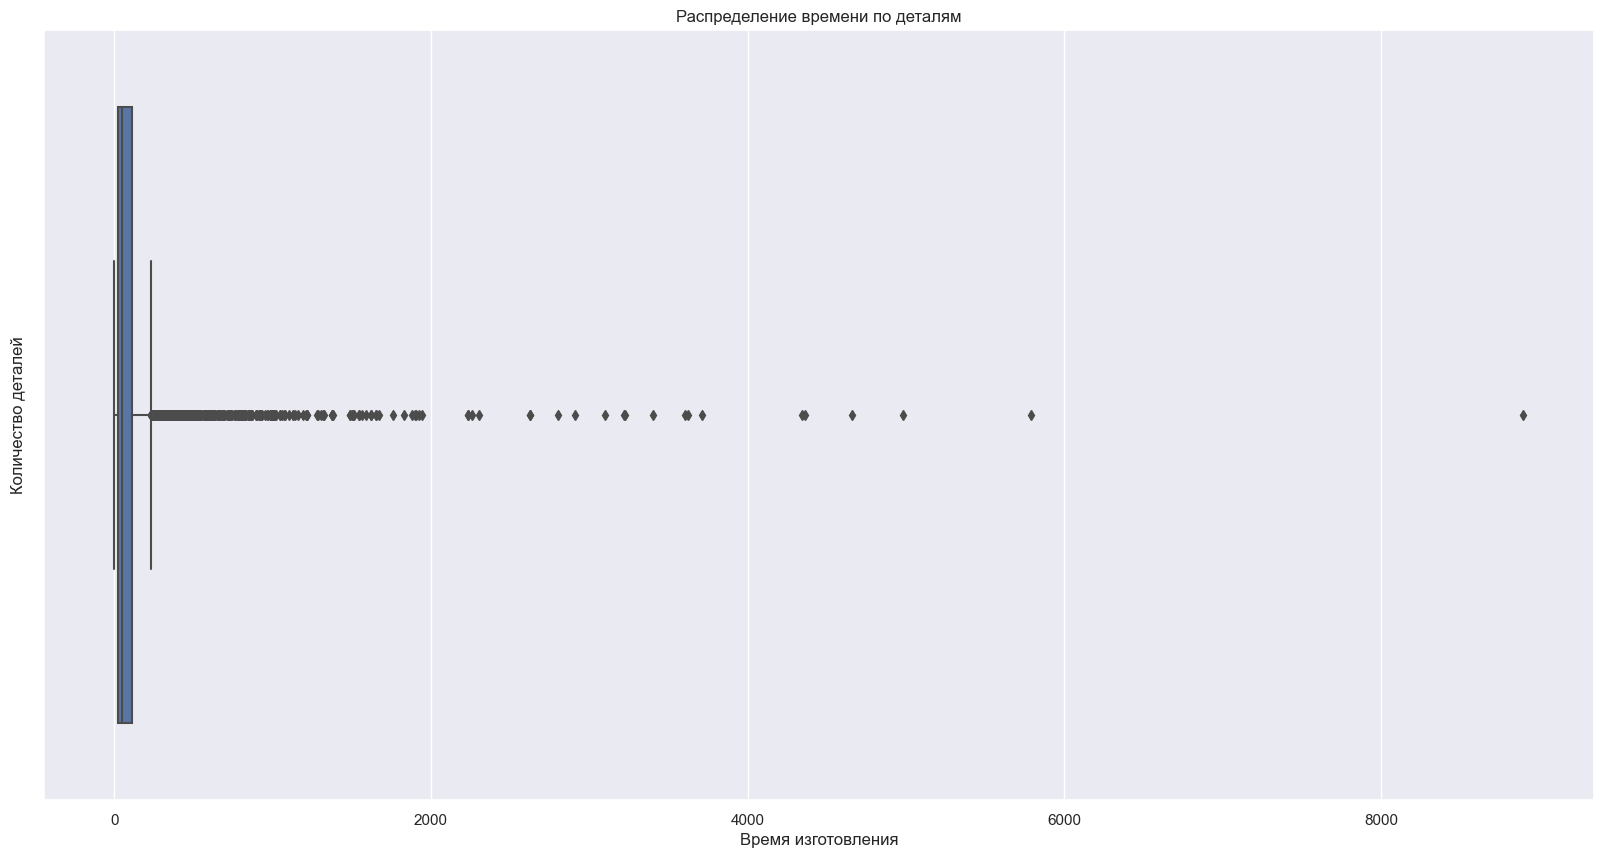

In [542]:
ax = sns.boxplot(time_df.time)
ax.set_title('Распределение времени по деталям')
ax.set_ylabel('Количество деталей')
ax.set_xlabel('Время изготовления')

В данных явно присутствует некоторое количество выбросов.

In [543]:
translit('201017814b-1-SAM', 'ru')

'201017814б-1-САМ'

In [544]:
time_df.head()

part_name  time             order
0  201017814b-1-SAM-Vs_517_1247_1_831_7    77  201017814b-1-SAM
1    211014588-OPR-Vs_577_1547_1_831_32    29     211014588-OPR
2     221029912-KZN-Vs_707_992_1_831_93    23     221029912-KZN
3    221006102v-OPR-Vs_577_647_1_831_87    84    221006102v-OPR
4    211017096b-OPR-Ns_175_404_1_611_45    83    211017096b-OPR

In [545]:
time_df['order_ru'] = time_df['order'].apply(lambda x: translit(x, 'ru'))

In [546]:
time_df.head()

part_name  time             order  \
0  201017814b-1-SAM-Vs_517_1247_1_831_7    77  201017814b-1-SAM   
1    211014588-OPR-Vs_577_1547_1_831_32    29     211014588-OPR   
2     221029912-KZN-Vs_707_992_1_831_93    23     221029912-KZN   
3    221006102v-OPR-Vs_577_647_1_831_87    84    221006102v-OPR   
4    211017096b-OPR-Ns_175_404_1_611_45    83    211017096b-OPR   

           order_ru  
0  201017814б-1-САМ  
1     211014588-ОПР  
2     221029912-КЗН  
3    221006102в-ОПР  
4    211017096б-ОПР

In [547]:
order_df = time_df[['order', 'order_ru']].copy()

order_df.drop_duplicates(inplace=True)

In [548]:
order_df.to_excel('orders.xlsx')

После некоторых мнипуляций на другой машине и сбора данных xml тоже с помощью python. Появился список найденных файлов. Подгрузим его и состыкуем с имеющимся датасетом, чтобы получить пути к найденным файлам.

In [549]:
found_xmls = pd.read_excel('data/found_xmls.xlsx', index_col=0)

found_xmls.head()

order          order_ru  \
0  201017814b-1-SAM  201017814б-1-САМ   
1     211014588-OPR     211014588-ОПР   
2     221029912-KZN     221029912-КЗН   
3    221006102v-OPR    221006102в-ОПР   
4    211017096b-OPR    211017096б-ОПР   

                                          path  pure_oder  
0                data/XML/201017814б-1-САМ.XML  201017814  
1        data/XML/211014588-ОПР 19.07.2022.XML  211014588  
2                   data/XML/221029912-КЗН.XML  221029912  
3  data/XML/221006102в-ОПР_15092022_154026.xml  221006102  
4  data/XML/211017096б-ОПР_31082022_102710.xml  211017096

Оставим столбец order в качестве связующего и столбец с путями, остальные уберем. Поединим с основным датафреймом.

In [550]:
found_xmls.drop(['order_ru', 'pure_oder'], axis=1)

order                                         path
0      201017814b-1-SAM                data/XML/201017814б-1-САМ.XML
1         211014588-OPR        data/XML/211014588-ОПР 19.07.2022.XML
2         221029912-KZN                   data/XML/221029912-КЗН.XML
3        221006102v-OPR  data/XML/221006102в-ОПР_15092022_154026.xml
4        211017096b-OPR  data/XML/211017096б-ОПР_31082022_102710.xml
...                 ...                                          ...
17655     221010739-BLR                   data/XML/221010739-БЛР.XML
17688        221020843a                      data/XML/221020843а.XML
17701        221020844a                      data/XML/221020844а.XML
17721        221020848a                      data/XML/221020848а.XML
17741        221020849b                      data/XML/221020849б.XML

[643 rows x 2 columns]

In [551]:
time_df = time_df.merge(found_xmls.drop(['order_ru', 'pure_oder'], axis=1), on='order')

Уберем лишние уже использованные столбцы.

In [552]:
time_df.drop(['order','order_ru'], axis=1, inplace=True)

time_df.head()

part_name  time                           path
0   201017814b-1-SAM-Vs_517_1247_1_831_7    77  data/XML/201017814б-1-САМ.XML
1     201017814b-1-SAM-N_205_745_2_711_2   207  data/XML/201017814б-1-САМ.XML
2   201017814b-1-SAM-Ns_717_747_1_611_11    93  data/XML/201017814б-1-САМ.XML
3  201017814b-1-SAM-Ns_997_1247_1_611_15    46  data/XML/201017814б-1-САМ.XML
4   201017814b-1-SAM-Ns_417_1247_1_611_4    64  data/XML/201017814б-1-САМ.XML

## Обработка файлов заказа

Выделим дополнительные признаки из наименования деталей.

In [553]:
time_df['part_feats'] = time_df['part_name'].apply(lambda x: re.findall(
    r'(\w+?)_(\d+?)_(\d+?)_(\d+?)_(\d+)_?(\d+)?', x)[0])

In [554]:
for ind in tqdm(time_df.index):
    if len(time_df.loc[ind, 'part_feats'][4]) > 1:
        time_df.loc[ind, 'part_type'] = time_df.loc[ind, 'part_feats'][0]
        time_df.loc[ind, 'part_length'] = time_df.loc[ind, 'part_feats'][1]
        time_df.loc[ind, 'part_width'] = time_df.loc[ind, 'part_feats'][2]
        time_df.loc[ind, 'part_amount'] = time_df.loc[ind, 'part_feats'][3]
        time_df.loc[ind, 'part_goemID'] = time_df.loc[ind, 'part_feats'][4]
        time_df.loc[ind, 'part_number'] = time_df.loc[ind, 'part_feats'][5]
    else:
        time_df.loc[ind, 'part_type'] = time_df.loc[ind, 'part_feats'][0]
        time_df.loc[ind, 'part_length'] = time_df.loc[ind, 'part_feats'][2]
        time_df.loc[ind, 'part_width'] = time_df.loc[ind, 'part_feats'][3]
        time_df.loc[ind, 'part_amount'] = time_df.loc[ind, 'part_feats'][4]
        time_df.loc[ind, 'part_goemID'] = time_df.loc[ind, 'part_feats'][5]
        time_df.loc[ind, 'part_number'] = time_df.loc[ind, 'part_feats'][1]

100%|██████████| 17389/17389 [00:14<00:00, 1233.90it/s]


In [555]:
time_df.head()

part_name  time                           path  \
0   201017814b-1-SAM-Vs_517_1247_1_831_7    77  data/XML/201017814б-1-САМ.XML   
1     201017814b-1-SAM-N_205_745_2_711_2   207  data/XML/201017814б-1-САМ.XML   
2   201017814b-1-SAM-Ns_717_747_1_611_11    93  data/XML/201017814б-1-САМ.XML   
3  201017814b-1-SAM-Ns_997_1247_1_611_15    46  data/XML/201017814б-1-САМ.XML   
4   201017814b-1-SAM-Ns_417_1247_1_611_4    64  data/XML/201017814б-1-САМ.XML   

                    part_feats part_type part_length part_width part_amount  \
0   (Vs, 517, 1247, 1, 831, 7)        Vs         517       1247           1   
1     (N, 205, 745, 2, 711, 2)         N         205        745           2   
2   (Ns, 717, 747, 1, 611, 11)        Ns         717        747           1   
3  (Ns, 997, 1247, 1, 611, 15)        Ns         997       1247           1   
4   (Ns, 417, 1247, 1, 611, 4)        Ns         417       1247           1   

  part_goemID part_number  
0         831           7  
1         711           2  
2         611          11  
3         611          15  
4         611           4

Так как нас волнует время на целую панель, попробуем объединить две половинки и сложить время. Сгруппируем элементы.

In [556]:
time_df = time_df.groupby(['part_length','part_width','part_amount','part_goemID','part_number','path'], as_index=False).agg({'time':'sum'})

Рассмотрим на примере первый заказ. Разберем структуру xml файла и данные, которые можно извлечь из него.

In [557]:
time_df[(time_df['path'] == 'data/XML/201017814б-1-САМ.XML')]

part_length part_width part_amount part_goemID part_number  \
1162        1287        747           1         611          16   
2056         175        747           1         611           1   
2685         205        745           2         711           2   
2787         207       1247           2         611           3   
4264         417       1247           1         611           4   
4712         507        745           1         711           5   
4722         515        745           1         711           6   
4725         517       1247           1         831           7   
4915         557       1247           2         611           9   
4980         557        747           2         611           8   
5456         622        745           1         711          10   
6033         717       1247           2         611          12   
6042         717        747           1         611          11   
6669         832       1247           1         611          13   
7268         997       1247           1         611          15   
7290         997        747           1         611          14   

                               path  time  
1162  data/XML/201017814б-1-САМ.XML   210  
2056  data/XML/201017814б-1-САМ.XML   336  
2685  data/XML/201017814б-1-САМ.XML   244  
2787  data/XML/201017814б-1-САМ.XML   116  
4264  data/XML/201017814б-1-САМ.XML   107  
4712  data/XML/201017814б-1-САМ.XML   345  
4722  data/XML/201017814б-1-САМ.XML    34  
4725  data/XML/201017814б-1-САМ.XML   158  
4915  data/XML/201017814б-1-САМ.XML   107  
4980  data/XML/201017814б-1-САМ.XML   123  
5456  data/XML/201017814б-1-САМ.XML    74  
6033  data/XML/201017814б-1-САМ.XML    72  
6042  data/XML/201017814б-1-САМ.XML   288  
6669  data/XML/201017814б-1-САМ.XML    57  
7268  data/XML/201017814б-1-САМ.XML    91  
7290  data/XML/201017814б-1-САМ.XML   115

In [558]:
xml_root = ET.parse('data/XML/201017814б-1-САМ.XML').getroot()

Распечатаем содержимое и ознакомимся с внутренней архитектурой файлов заказа.

In [559]:
recur_print(xml_root,print_attrib=True)

 Elements 
     {}
   N1766519470 None {'cfnName': 'Заказы', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '254.1.54.26', 'cfnLevel': 'caeFolder', 'cfnElement': 'cadOrdersFolder', 'proMarking': '', 'proPriceKey': ''}
   N14900662 None {'cfnName': 'Заказ 201017814б-1-САМ', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caeFolder', 'cfnElement': 'cadOrderFolder', 'proShippingCount': '2', 'proOemOrder': 'oemNone', 'proDivisionOrder': 'vezSamara', 'proOemXML': 'oemNone', 'proDivisionXML': 'vezMain', 'proTechID': '0', 'proTimeLine': '0'}
   N206692362 None {'cfnName': 'Установки', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caeFolder', 'cfnElement': 'cadUnitsFolder', 'proMarking': '', 'proPriceKey': ''}
   N176062374 None {'cfnName': 'Установка 1', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caeFolder', 'cfnElement': 'cadUnitFolder', 'proFrontType': 'frVerosa500_078_6_3', 'proUnitName': 'ВЕРОСА-500-078-03-00-У3'}
   N

Архитектура файла представляет собой 2 раздела:
* Элементы - содержит перечень всех элементов с характерными своействами. При этом каждый элемент имеет хэшированный код, отвечающий набору аттрибутов элемента.
* Структура - содержит иерархическое дерево вложенности элементов состава с аттрибом в виде количества.

Попробуем найти вручную элементы со следующими признаками:

In [560]:
time_df[(time_df['path'] == 'data/XML/201017814б-1-САМ.XML')&(time_df.part_length == '517')]

part_length part_width part_amount part_goemID part_number  \
4725         517       1247           1         831           7   

                               path  time  
4725  data/XML/201017814б-1-САМ.XML   158

В ходе ручных поисках, в разделе элементов находится 3 элемента:

*N219834708 None {'cfnName': 'Панель', 'cfnDesignation': 'ТЕКИ 99.953.22.02.21.000-1247.0517.01.000СБ', 'cfnAmount': '1', 'cfnNote': 'панель-поддон', 'cfnLevel': 'caeAssembly', 'cfnElement': 'cadPanelAssem', 'proMarking': '', 'proLength': '517', 'proHeight': '1247', 'proDepth': '50', 'proPanelTypeKey': 'pnTankPanel', 'proPanelSpecialTypeKey': 'hlCollection', 'proPanelFixedType': 'pfxScrewOuter', 'proHandHoldersCount': '0', 'proFestingCount': '0', 'proLockHoldersCount': '0', 'proPanelGeomID': '831', 'proPanelDesignCADKey': 'pndc50_Tank', 'proPanelMaterialOuter': 'maSheetZincCoated55', 'proPanelMaterialInner': 'maSheetZincCoated70', 'proIsPaintedOuter': 'false', 'proIsPaintedInner': 'false', 'proIsFlooded': 'false', 'proPanelFiller': 'pfNone', 'proFloodMass': '0', 'proHash': '1417894582', 'proIsWindows': 'false', 'proIsLamp': 'false', 'proHoleCount': '29', 'proMountHoleCount': '14', 'proHolesUnique': '1'}*

*N1363633513 None {'cfnName': 'Обшивка панели', 'cfnDesignation': 'ТЕКИ 99.953.00.02.20.001-1247.0517.00.000', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caeDetail', 'cfnElement': 'cadPanel', 'proMarking': '', 'proWeigt': '3.852049783725', 'proLength': '517', 'proHeight': '1247', 'proMonolayerWidth': '650.45', 'proMonolayerHeight': '1380.45', 'proPanelConerChopOff': '88.3', 'proPanelCrease': '0', 'proIsPainted': 'false', 'proIsFlooded': 'false', 'proPanelFiller': 'pfNone', 'proMaterial': '193', 'proMaterialStr': 'Прокат 02-0,55х1250х2500-Ц140-М-ПС-ГОСТ 14918-2020', 'proPanelInner': 'false'}*

*N912379215 None {'cfnName': 'Обшивка панели', 'cfnDesignation': 'ТЕКИ 99.953.22.02.01.002-1247.0517.00.000', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caeDetail', 'cfnElement': 'cadPanel', 'proMarking': '', 'proWeigt': '3.995656418754', 'proLength': '517', 'proHeight': '1247', 'proMonolayerWidth': '565.07', 'proMonolayerHeight': '1295.07', 'proPanelConerChopOff': '46.74', 'proPanelCrease': '0', 'proIsPainted': 'false', 'proIsFlooded': 'false', 'proPanelFiller': 'pfNone', 'proMaterial': '194', 'proMaterialStr': 'Прокат 02-0,7х1250х2500-Ц140-М-ПС-ГОСТ 14918-2020', 'proPanelInner': 'true'}*



Хорошо видно, что параметры соответствуют параметру панели, но у нас две детали, а нашлось 3 элемента. Дело в том, что мы имеем дело с половинками панели, а в файле заказа содежратся как сама готовая панель, так и ее половинки. Поэтому необходимо собрать всю нужную нам информацию из всех источников. Заметим, что признак 'part_type' указнывает на часть панели. V - верх или наружная часть, а N - нижняя или внутрення.

Напишем функция, которая ищет и выводит на экран структуру вложенности в панель с именами элементов, чтобы понять, как устроены данные о панели и обшивках.

In [561]:
def part_search(staructure, elements, tag, level=0):
    """Функция печати структуры панели из xml файла заказа

    Args:
        staructure (ET.Element): раздел Структуры xml
        elements (ET.Element): раздел Элементов xml
        tag (str): таг элемента
        level (int, optional): уровень печати. Defaults to 0.
    """
    for child in staructure: # пройдемся по всем элементам в структуре
        if tag: # Если таг не None, тогда ищем нужный элемент
            if child.tag == tag: 
                # Если нашли, то печатаем его
                print(child.tag, elements.find(child.tag).attrib['cfnName'])
                # Вызываем рекурсивно далее функцию, при tag = None
                part_search(child, elements, None, level=level+2)
            else:
                # Если не нашли, рекурсивно идем дальше
                part_search(child, elements, tag)
        else:
            # Если уже tag = None, то печатаем внутренности,
            # параллельно выводя аттрибут имени
            print(' '*level, child.tag, elements.find(child.tag).attrib['cfnName'])
            part_search(child, elements, None, level=level+2)

In [562]:
part_search(xml_root[1], xml_root[0], 'N219834708')

N219834708 Панель
   N286767916 Положение грани 1
   N1651250815 Коллекция отверстий
     N2006422446 Круглое отверстие
     N226455325 Круглое отверстие
     N1399641216 Круглое отверстие
     N1836245679 Круглое отверстие
     N538301708 Круглое отверстие
     N1666172788 Круглое отверстие
     N1854016631 Круглое отверстие
     N1579983601 Круглое отверстие
     N4797983 Круглое отверстие
     N655944764 Круглое отверстие
     N2128057931 Круглое отверстие
     N1261693332 Круглое отверстие
     N52660847 Круглое отверстие
     N485608064 Круглое отверстие
     N426444410 Круглое отверстие
     N497337406 Круглое отверстие
     N1698939845 Круглое отверстие
     N2119330772 Круглое отверстие
     N495614716 Круглое отверстие
     N485065063 Круглое отверстие
     N7142714 Круглое отверстие
     N334622674 Круглое отверстие
     N277147887 Круглое отверстие
     N946470117 Круглое отверстие
     N402677360 Круглое отверстие
     N1016925095 Круглое отверстие
     N1185533414 Круглое 

Из структуры видно, что Панель содержит на втором уровне:

* Положение грани
* Коллекцию отверстий
* Сущность загрузки линии, которую необходимо уточнить
* Обшивки
* Материал заполнения
* Метизы для установки

Посмотрим на свойства коллекции отверстия:

   *N1651250815 None {'cfnName': 'Коллекция отверстий', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caePropCollection', 'cfnElement': 'cadHoleCollection', 'proHoleCount': '29', 'proTag': '0'}*

   *N2006422446 None {'cfnName': 'Круглое отверстие', 'cfnDesignation': '', 'cfnAmount': '1', 'cfnNote': '', 'cfnLevel': 'caePropCollectionItem', 'cfnElement': 'cadCircHole', 'proCenterXCoord': '258.5', 'proCenterYCoord': '1110', 'proDiam': '58', 'proIsInner': 'true', 'proIsOuter': 'true', 'proHoleTag': 'hltgTank'}*


Видно, что сущность "коллекция отверстий" почти не ценной содержит информации. А вот каждое отверстие содержит как диаметр, там и координаты положения, а также признак принадлежности к внутренней или наружной обшивке. Признаки 'proIsInner', 'proIsOuter' как раз говорят об этом отношении. Кроме того, из имено можно понять какой характер отверстия мы имеем - круглое или прямоугольное, об этом говорит с типа свойства "cfnElement".

После изучения данных вырисовывается порядок извлечения данных об обшивках:

1. Найти в ***Элементах*** панель соответствующих размеров и типа, забрать ее таг-номер
2. Найти в ***Структуре*** панель и обрабатывая все отверстия входящие в состав коллекции добавлять эти данные в список для каждой соответствующей обшивке.

In [563]:
time_df[(time_df['path'] == 'data/XML/201017814б-1-САМ.XML')&(time_df.part_length == '517')]

part_length part_width part_amount part_goemID part_number  \
4725         517       1247           1         831           7   

                               path  time  
4725  data/XML/201017814б-1-САМ.XML   158

Напишем функцию получения параметров для панели с таг-номером "N219834708".

In [564]:
def panel_info_get(staructure, elements, tag, res_dict=None):
    # Инициалазируем переменную, куда будем писать информацию об отверствиях
    res_dict = res_dict or  {
            'panel': [],
            'holes': []
        }
    for child in staructure: # пройдемся по всем элементам в структуре
        if tag: # Если таг не None, тогда ищем нужный элемент
            if child.tag == tag: 
                child_attrib = elements.find(child.tag).attrib
                # Пишем параметры панели
                res_dict['panel'] = [
                    child_attrib['proDepth'],
                    child_attrib['proPanelTypeKey'],
                    child_attrib['proPanelSpecialTypeKey'],
                    child_attrib['proPanelFixedType'],
                    child_attrib['proHandHoldersCount'],
                    child_attrib['proFestingCount'],
                    child_attrib['proLockHoldersCount'],
                    child_attrib['proPanelDesignCADKey'],
                    child_attrib['proIsFlooded'],
                    child_attrib['proIsWindows'],
                    child_attrib['proIsLamp'],
                    child_attrib['proHoleCount'],
                    child_attrib['proMountHoleCount'],
                    child_attrib.get('proHolesUnique'),
                    ]
                res_dict['panel'].append(child_attrib['proPanelMaterialInner'])
                res_dict['panel'].append(child_attrib['proPanelMaterialOuter'])
                # Вызываем рекурсивно далее функцию, при tag = None
                panel_info_get(child, elements, None, res_dict=res_dict)
            else:
                # Рекурсивно идем дальше
                panel_info_get(child, elements, tag,  res_dict=res_dict)
        else:
            # Заберем параметры элемента из структуры Элементов
            child_attrib = elements.find(child.tag).attrib
            
            if child_attrib['cfnElement'] == 'cadCircHole':
                res_dict['holes'].append(
                    (
                        int(child.attrib['cfnAmount']),
                        float(child_attrib['proCenterXCoord']),
                        float(child_attrib['proCenterYCoord']),
                        float(child_attrib['proDiam']),
                        0,
                        0                  
                    )
                )
                
            elif child_attrib['cfnElement'] == 'cadRectHole':
                res_dict['holes'].append(
                        (
                            int(child.attrib['cfnAmount']),
                            float(child_attrib['proLeftXCoord']),
                            float(child_attrib['proBottomYCoord']),
                            float(child_attrib['proWidth']),                   
                            float(child_attrib['proHeight']),                   
                            float(child_attrib['proEdgeRoundSize']),                   
                        )
                    )
            # Пишем параметры отверстий
            panel_info_get(child, elements, None, res_dict=res_dict)
    return res_dict

In [565]:
tmp = panel_info_get(xml_root[1], xml_root[0], 'N219834708')

In [566]:
np.array(tmp['holes'])

array([[1.000e+00, 2.585e+02, 1.110e+03, 5.800e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.100e+01, 5.000e+01, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.100e+01, 4.323e+02, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.100e+01, 8.147e+02, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.100e+01, 1.197e+03, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 5.000e+01, 1.100e+01, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 5.000e+01, 1.236e+03, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 2.585e+02, 1.100e+01, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 2.585e+02, 1.236e+03, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 4.670e+02, 1.100e+01, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 4.670e+02, 1.236e+03, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 5.060e+02, 5.000e+01, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 5.060e+02, 4.323e+02, 1.000e+01, 0.000e+00, 0.000e+00],
       [1.000e+00, 5.060e

К сожалению, исходя из параметров деталей, полученных из job-листов, не получится определить точно к какой панели в заказе они относятся, поэтому для детали, к которым нашлось более 1 панели, придется выбросить из рассмотрения.

In [567]:
def get_holes_information(
    structure: ET.Element,
    elements: ET.Element,
    part_length,
    part_width,
    part_amount,
    part_goemID
    ):
    
    # Найдем панель с нужными нам параметрами
    panel_tag = elements.findall(f"*[@proLength='{part_length}'][@proHeight='{part_width}'][@cfnAmount='{part_amount}'][@proPanelGeomID='{part_goemID}']")
    res_dict = {
        'panel': [],
        'holes': []
    }
    
    if len(panel_tag) == 1:
        res_dict = {
            'panel': [],
            'holes': []
        }

        return panel_info_get(structure, elements, panel_tag[0].tag)

Проверим работу функции на 1 элементе.

In [568]:
i = 1

In [569]:
xml_root = ET.parse(time_df.loc[i, 'path']).getroot()
get_holes_information(
        xml_root[1],
        xml_root[0],
        time_df.loc[i, 'part_length'],
        time_df.loc[i, 'part_width'],
        time_df.loc[i, 'part_amount'],
        time_df.loc[i, 'part_goemID'],
        )

{'panel': ['50',
  'pnUndrawablePanel',
  'hlCollection',
  'pfxScrewOuter',
  '0',
  '0',
  '0',
  'pndc50_600_Undrawble',
  'false',
  'false',
  'false',
  '45',
  '22',
  '1',
  'maSheetZincCoated100',
  'maSheetZincCoated100'],
 'holes': [(1, 50.0, 63.5, 900.0, 2200.0, 0.0),
  (1, 11.0, 50.0, 10.0, 0, 0),
  (1, 11.0, 421.2, 10.0, 0, 0),
  (1, 11.0, 792.3, 10.0, 0, 0),
  (1, 11.0, 1163.5, 10.0, 0, 0),
  (1, 11.0, 1534.7, 10.0, 0, 0),
  (1, 11.0, 1905.9, 10.0, 0, 0),
  (1, 11.0, 2277.0, 10.0, 0, 0),
  (1, 50.0, 11.0, 10.0, 0, 0),
  (1, 50.0, 2316.0, 10.0, 0, 0),
  (1, 350.3, 11.0, 10.0, 0, 0),
  (1, 350.3, 2316.0, 10.0, 0, 0),
  (1, 650.7, 11.0, 10.0, 0, 0),
  (1, 650.7, 2316.0, 10.0, 0, 0),
  (1, 951.0, 11.0, 10.0, 0, 0),
  (1, 951.0, 2316.0, 10.0, 0, 0),
  (1, 990.0, 50.0, 10.0, 0, 0),
  (1, 990.0, 421.2, 10.0, 0, 0),
  (1, 990.0, 792.3, 10.0, 0, 0),
  (1, 990.0, 1163.5, 10.0, 0, 0),
  (1, 990.0, 1534.7, 10.0, 0, 0),
  (1, 990.0, 1905.9, 10.0, 0, 0),
  (1, 990.0, 2277.0, 10.0, 0, 

In [570]:
time_df['holes'] = None

for i in tqdm(time_df.index):
    xml_root = ET.parse(time_df.at[i, 'path']).getroot()
    tmp = get_holes_information(
        xml_root[1],
        xml_root[0],
        time_df.at[i, 'part_length'],
        time_df.at[i, 'part_width'],
        time_df.at[i, 'part_amount'],
        time_df.at[i, 'part_goemID'],
        )
    
    if tmp:
        time_df.at[i, 'panel_depth'] = tmp['panel'][0]
        time_df.at[i, 'panel_TypeKey'] =  tmp['panel'][1]
        time_df.at[i, 'panel_SpecialTypeKey'] = tmp['panel'][2]
        time_df.at[i, 'panel_FixedType'] = tmp['panel'][3]
        time_df.at[i, 'HandHoldersCount'] = tmp['panel'][4]
        time_df.at[i, 'FestingCount'] =  tmp['panel'][5]
        time_df.at[i, 'LockHoldersCount'] = tmp['panel'][6]
        time_df.at[i, 'PanelDesignCADKey'] = tmp['panel'][7]
        time_df.at[i, 'IsFlooded'] = tmp['panel'][8]
        time_df.at[i, 'IsWindows'] = tmp['panel'][9]
        time_df.at[i, 'IsLamp'] = tmp['panel'][10]
        time_df.at[i, 'HoleCount'] = tmp['panel'][11]
        time_df.at[i, 'MountHoleCount'] = tmp['panel'][12]
        time_df.at[i, 'HolesUnique'] = tmp['panel'][13]
        time_df.at[i, 'panel_InnerMAterial'] = tmp['panel'][14]
        time_df.at[i, 'panel_OuterMAterial'] = tmp['panel'][15]
        
            
        time_df.at[i, 'holes'] = tmp['holes']

100%|██████████| 7298/7298 [02:28<00:00, 49.06it/s] 


Уберем детали, на которые мы не получили данные или получили более 1 панели в файл заказа.

In [571]:
time_df.head()

part_length part_width part_amount part_goemID part_number  \
0        1000       1287           1        6144               
1        1001       2327           1        6144          12   
2        1005       1977           1         722          67   
3        1007       1247           2         611          91   
4        1007        175           1         622          68   

                                          path  time  \
0  data/XML/211021793е-КОМ_15092022_150812.xml   238   
1  data/XML/221001576б-СПБ_09122022_154227.xml   733   
2                data/XML/201030047е-1-САМ.XML   211   
3  data/XML/221034461г-ОПР_14092022_112622.xml    42   
4                data/XML/201030047е-1-САМ.XML   495   

                                               holes panel_depth  \
0  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 445.7,...          50   
1  [(1, 50.0, 63.5, 900.0, 2200.0, 0.0), (1, 11.0...          50   
2  [(1, 93.0, 1262.5, 9.0, 0, 0), (1, 93.0, 1373....          50   
3  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 432.3,...          50   
4  [(1, 84.0, 57.0, 59.0, 0, 0), (1, 129.0, 132.0...          50   

         panel_TypeKey panel_SpecialTypeKey panel_FixedType HandHoldersCount  \
0    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
1    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
2  pnWithdrawablePanel         hlCollection         pfxNone                2   
3    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
4    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   

  FestingCount LockHoldersCount     PanelDesignCADKey IsFlooded IsWindows  \
0            0                0  pndc50_600_Undrawble     false     false   
1            0                0  pndc50_600_Undrawble     false     false   
2            0                0    pndc50_Withdrawble      true     false   
3            0                0      pndc50_Undrawble      true     false   
4            0                0      pndc50_Undrawble      true     false   

  IsLamp HoleCount MountHoleCount HolesUnique           panel_InnerMAterial  \
0  false        32             16           1          maSheetZincCoated100   
1  false        45             22           1          maSheetZincCoated100   
2  false         4              0           1  maSheetZincCoatedPolymeric55   
3  false        32             16           1           maSheetZincCoated55   
4  false         3              0           1  maSheetZincCoatedPolymeric55   

            panel_OuterMAterial  
0          maSheetZincCoated100  
1          maSheetZincCoated100  
2  maSheetZincCoatedPolymeric55  
3           maSheetZincCoated55  
4  maSheetZincCoatedPolymeric55

In [572]:
time_df.drop(['path','part_number'], axis=1, inplace=True)

In [573]:
time_df.drop(index=time_df[time_df.panel_depth.isna()].index, axis=0, inplace=True)

In [574]:
time_df.fillna(0, inplace=True)

In [575]:
time_df.head()

part_length part_width part_amount part_goemID  time  \
0        1000       1287           1        6144   238   
1        1001       2327           1        6144   733   
2        1005       1977           1         722   211   
3        1007       1247           2         611    42   
4        1007        175           1         622   495   

                                               holes panel_depth  \
0  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 445.7,...          50   
1  [(1, 50.0, 63.5, 900.0, 2200.0, 0.0), (1, 11.0...          50   
2  [(1, 93.0, 1262.5, 9.0, 0, 0), (1, 93.0, 1373....          50   
3  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 432.3,...          50   
4  [(1, 84.0, 57.0, 59.0, 0, 0), (1, 129.0, 132.0...          50   

         panel_TypeKey panel_SpecialTypeKey panel_FixedType HandHoldersCount  \
0    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
1    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
2  pnWithdrawablePanel         hlCollection         pfxNone                2   
3    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   
4    pnUndrawablePanel         hlCollection   pfxScrewOuter                0   

  FestingCount LockHoldersCount     PanelDesignCADKey IsFlooded IsWindows  \
0            0                0  pndc50_600_Undrawble     false     false   
1            0                0  pndc50_600_Undrawble     false     false   
2            0                0    pndc50_Withdrawble      true     false   
3            0                0      pndc50_Undrawble      true     false   
4            0                0      pndc50_Undrawble      true     false   

  IsLamp HoleCount MountHoleCount HolesUnique           panel_InnerMAterial  \
0  false        32             16           1          maSheetZincCoated100   
1  false        45             22           1          maSheetZincCoated100   
2  false         4              0           1  maSheetZincCoatedPolymeric55   
3  false        32             16           1           maSheetZincCoated55   
4  false         3              0           1  maSheetZincCoatedPolymeric55   

            panel_OuterMAterial  
0          maSheetZincCoated100  
1          maSheetZincCoated100  
2  maSheetZincCoatedPolymeric55  
3           maSheetZincCoated55  
4  maSheetZincCoatedPolymeric55

In [576]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7015 entries, 0 to 7297
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   part_length           7015 non-null   object
 1   part_width            7015 non-null   object
 2   part_amount           7015 non-null   object
 3   part_goemID           7015 non-null   object
 4   time                  7015 non-null   int32 
 5   holes                 7015 non-null   object
 6   panel_depth           7015 non-null   object
 7   panel_TypeKey         7015 non-null   object
 8   panel_SpecialTypeKey  7015 non-null   object
 9   panel_FixedType       7015 non-null   object
 10  HandHoldersCount      7015 non-null   object
 11  FestingCount          7015 non-null   object
 12  LockHoldersCount      7015 non-null   object
 13  PanelDesignCADKey     7015 non-null   object
 14  IsFlooded             7015 non-null   object
 15  IsWindows             7015 non-null   

Отлично, наконец получен датасет, с которым можно работать. Заметим, что в датасете остались все те параметры, которые можно получить из файлов заказа. Это очень важно для построения потом сервиса для предсказания.

Сохраним датасет и продолжим работу уже с признаками самого датасета.

In [577]:
time_df.to_csv('data/data_panels.csv', sep='|', index=None)

# Подгрузим очищенные данные и подготовим их для обучения

In [578]:
df = pd.read_csv('data/data_panels.csv', sep='|')

df.head()

part_length  part_width  part_amount  part_goemID  time  \
0         1000        1287            1         6144   238   
1         1001        2327            1         6144   733   
2         1005        1977            1          722   211   
3         1007        1247            2          611    42   
4         1007         175            1          622   495   

                                               holes  panel_depth  \
0  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 445.7,...           50   
1  [(1, 50.0, 63.5, 900.0, 2200.0, 0.0), (1, 11.0...           50   
2  [(1, 93.0, 1262.5, 9.0, 0, 0), (1, 93.0, 1373....           50   
3  [(1, 11.0, 50.0, 10.0, 0, 0), (1, 11.0, 432.3,...           50   
4  [(1, 84.0, 57.0, 59.0, 0, 0), (1, 129.0, 132.0...           50   

         panel_TypeKey panel_SpecialTypeKey panel_FixedType  HandHoldersCount  \
0    pnUndrawablePanel         hlCollection   pfxScrewOuter                 0   
1    pnUndrawablePanel         hlCollection   pfxScrewOuter                 0   
2  pnWithdrawablePanel         hlCollection         pfxNone                 2   
3    pnUndrawablePanel         hlCollection   pfxScrewOuter                 0   
4    pnUndrawablePanel         hlCollection   pfxScrewOuter                 0   

   FestingCount  LockHoldersCount     PanelDesignCADKey  IsFlooded  IsWindows  \
0             0                 0  pndc50_600_Undrawble      False      False   
1             0                 0  pndc50_600_Undrawble      False      False   
2             0                 0    pndc50_Withdrawble       True      False   
3             0                 0      pndc50_Undrawble       True      False   
4             0                 0      pndc50_Undrawble       True      False   

   IsLamp  HoleCount  MountHoleCount  HolesUnique  \
0   False         32              16            1   
1   False         45              22            1   
2   False          4               0            1   
3   False         32              16            1   
4   False          3               0            1   

            panel_InnerMAterial           panel_OuterMAterial  
0          maSheetZincCoated100          maSheetZincCoated100  
1          maSheetZincCoated100          maSheetZincCoated100  
2  maSheetZincCoatedPolymeric55  maSheetZincCoatedPolymeric55  
3           maSheetZincCoated55           maSheetZincCoated55  
4  maSheetZincCoatedPolymeric55  maSheetZincCoatedPolymeric55

In [579]:
raw_df = df.copy()

In [580]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7015 entries, 0 to 7014
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   part_length           7015 non-null   int64 
 1   part_width            7015 non-null   int64 
 2   part_amount           7015 non-null   int64 
 3   part_goemID           7015 non-null   int64 
 4   time                  7015 non-null   int64 
 5   holes                 7015 non-null   object
 6   panel_depth           7015 non-null   int64 
 7   panel_TypeKey         7015 non-null   object
 8   panel_SpecialTypeKey  7015 non-null   object
 9   panel_FixedType       7015 non-null   object
 10  HandHoldersCount      7015 non-null   int64 
 11  FestingCount          7015 non-null   int64 
 12  LockHoldersCount      7015 non-null   int64 
 13  PanelDesignCADKey     7015 non-null   object
 14  IsFlooded             7015 non-null   bool  
 15  IsWindows             7015 non-null   

Проверим дубликаты

In [581]:
df.duplicated().sum()

341

In [582]:
df.drop_duplicates(inplace=True, ignore_index=True)

При перезагрузке датасета, у нас встали на место типы. Это хорошо, потому что мы пропустили часть переопределения типов. И все же остались типы, которые нам следует закодировать.

# Предобработка данных

## Переведем тип bool к типу int

In [583]:
df.select_dtypes(include=['bool']).columns

Index(['IsFlooded', 'IsWindows', 'IsLamp'], dtype='object')

In [584]:
df[df.select_dtypes(include=['bool']).columns] = df[df.select_dtypes(include=['bool']).columns].astype('int')

Чтобы наша модель могла нормально работать с данными, нам необходимо их перевести в числовой формат. Выведем все столбцы формата object.

In [585]:
df.select_dtypes(include=['object']).columns

Index(['holes', 'panel_TypeKey', 'panel_SpecialTypeKey', 'panel_FixedType',
       'PanelDesignCADKey', 'panel_InnerMAterial', 'panel_OuterMAterial'],
      dtype='object')

Закодируем признак.

# Признак ***panel_TypeKey***, ***panel_SpecialTypeKey***, ***panel_FixedType***, ***PanelDesignCADKey***, ***part_goemID***, ***panel_depth***, ***panel_InnerMAterial*** и ***panel_OuterMAterial***

Посмотрим сколько значений содержит признак panel_TypeKey

In [586]:
df.panel_TypeKey.value_counts()

pnUndrawablePanel      4586
pnWithdrawablePanel     993
pnDoorPanel             975
pnTankPanel             120
Name: panel_TypeKey, dtype: int64

In [587]:
label_enc_feats = ['panel_TypeKey']

Посмотрим сколько значений содержит признак panel_SpecialTypeKey

In [588]:
df.panel_SpecialTypeKey.value_counts()

hlCollection           4680
hlNone                 1906
hlFrCooler               54
hlHeater                 13
hlEHeater                 8
hlStHeater                4
hlInletSupply             3
hlUltraVioletSupply       2
hlSotHumidSupply          1
hlStHumid                 1
hlRefriUnit2              1
hlRefriUnit1              1
Name: panel_SpecialTypeKey, dtype: int64

In [589]:
label_enc_feats.append('panel_SpecialTypeKey')

Посмотрим сколько значений содержит признак panel_FixedType

In [590]:
df.panel_FixedType.value_counts()

pfxScrewOuter    4363
pfxNone          1968
pfxScrewInner     343
Name: panel_FixedType, dtype: int64

In [591]:
label_enc_feats.append('panel_FixedType')

Посмотрим сколько значений содержит признак PanelDesignCADKey

In [592]:
df.PanelDesignCADKey.value_counts()

pndc50_Undrawble          3523
pndc50_Withdrawble        1591
pndc25                     808
pndc50_600_Undrawble       520
pndc50_600_Withdrawble     112
pndc50_Tank                 86
pndc50_600_Tank             34
Name: PanelDesignCADKey, dtype: int64

In [593]:
label_enc_feats.append('PanelDesignCADKey')

Признак ***part_goemID*** содержит массив значений. Давайте посмотрим на некоторые экземляры поближе.

In [594]:
df.part_goemID.nunique()

21

In [595]:
df.part_goemID = df.part_goemID.astype('str')

In [596]:
label_enc_feats.append('part_goemID')

Признак ***panel_depth*** содержит массив значений. Давайте посмотрим на некоторые экземляры поближе.

In [597]:
df.panel_depth.nunique()

2

In [598]:
df.panel_depth = df.panel_depth.astype('str')

In [599]:
label_enc_feats.append('panel_depth')

Признак ***panel_InnerMAterial*** и ***panel_OuterMAterial*** содержит массив значений. Давайте посмотрим на некоторые экземляры поближе.

In [600]:
df.panel_InnerMAterial.nunique(), df.panel_OuterMAterial.nunique()

(6, 4)

In [601]:
label_enc_feats.append('panel_InnerMAterial')
label_enc_feats.append('panel_OuterMAterial')

Закодируем признаки

In [602]:
label_enc_feats

['panel_TypeKey',
 'panel_SpecialTypeKey',
 'panel_FixedType',
 'PanelDesignCADKey',
 'part_goemID',
 'panel_depth',
 'panel_InnerMAterial',
 'panel_OuterMAterial']

In [603]:
data_processors = {}
for feat in label_enc_feats:
    data_processors[feat] = preprocessing.LabelEncoder()

    df[feat] = data_processors[feat].fit_transform(df[feat])

In [604]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   part_length           6674 non-null   int64 
 1   part_width            6674 non-null   int64 
 2   part_amount           6674 non-null   int64 
 3   part_goemID           6674 non-null   int32 
 4   time                  6674 non-null   int64 
 5   holes                 6674 non-null   object
 6   panel_depth           6674 non-null   int32 
 7   panel_TypeKey         6674 non-null   int32 
 8   panel_SpecialTypeKey  6674 non-null   int32 
 9   panel_FixedType       6674 non-null   int32 
 10  HandHoldersCount      6674 non-null   int64 
 11  FestingCount          6674 non-null   int64 
 12  LockHoldersCount      6674 non-null   int64 
 13  PanelDesignCADKey     6674 non-null   int32 
 14  IsFlooded             6674 non-null   int32 
 15  IsWindows             6674 non-null   

## Определимся с признаками для скалирования

In [605]:
df.nunique()

part_length              403
part_width               213
part_amount               11
part_goemID               21
time                     660
holes                   1946
panel_depth                2
panel_TypeKey              4
panel_SpecialTypeKey      12
panel_FixedType            3
HandHoldersCount           3
FestingCount               4
LockHoldersCount           3
PanelDesignCADKey          7
IsFlooded                  2
IsWindows                  2
IsLamp                     2
HoleCount                 43
MountHoleCount            12
HolesUnique                4
panel_InnerMAterial        6
panel_OuterMAterial        4
dtype: int64

In [606]:
data_processors['part_length'] = preprocessing.MinMaxScaler().fit(df[['part_length']])
data_processors['part_width'] = preprocessing.MinMaxScaler().fit(df[['part_width']])
data_processors['HoleCount'] = preprocessing.MinMaxScaler().fit(df[['HoleCount']])
data_processors['MountHoleCount'] = preprocessing.MinMaxScaler().fit(df[['MountHoleCount']])

In [607]:
df.part_length = data_processors['part_length'].transform(df[['part_length']])
df.part_width = data_processors['part_width'].transform(df[['part_width']])
df.HoleCount = data_processors['HoleCount'].transform(df[['HoleCount']])
df.MountHoleCount = data_processors['part_width'].transform(df[['MountHoleCount']])

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- MountHoleCount
Feature names seen at fit time, yet now missing:
- part_width




## Признак ***holes***

Признак holes при чтении из файла распознался как строка. Вернем ему исходное состояние.

In [608]:
df.holes = df.holes.progress_apply(lambda x:  np.array(ast.literal_eval(x)))

100%|██████████| 6674/6674 [00:04<00:00, 1353.30it/s]


Обучим объект для веткоризации текста, чтобы потом воспользоваться им в объекте для обработки отверстий.

In [609]:
corpus = df.holes.progress_apply(np.array2string).to_list()
vectorizer = HashingVectorizer(n_features=2**4)

data_processors['holes_vect'] = vectorizer.fit(corpus)

data_vect = data_processors['holes_vect'].transform(corpus).toarray()

100%|██████████| 6674/6674 [00:08<00:00, 755.82it/s] 


Обернем действия с массивами отверстий в объект, который далее сохраним в словарь с обработками.

In [610]:
class holes_tranfer():
    def get_array_feats(self, feature: str) -> None:
        """Метод создает признаки из массивов признака feature

        Args:
            feature (str): исходный признак
        """
        for index in df.index:
            try:
                tmp = self.df.at[index, feature].shape[1]
                sum_tmp = self.df.at[index, feature].sum(axis=0)
                mean_tmp = self.df.at[index, feature].mean(axis=0)
                min_tmp = self.df.at[index, feature].min(axis=0)
                max_tmp = self.df.at[index, feature].max(axis=0)
            except IndexError:
                sum_tmp = self.df.at[index, feature]
                mean_tmp = self.df.at[index, feature]
                min_tmp = self.df.at[index, feature]
                max_tmp = self.df.at[index, feature]
            for i in range(6):
                self.df.at[index, f'h_sum_{i}'] = sum_tmp[i]
                self.df.at[index, f'h_mean_{i}'] = mean_tmp[i]
                self.df.at[index, f'h_min_{i}'] = min_tmp[i]
                self.df.at[index, f'h_max_{i}'] = max_tmp[i]
    
    def __init__(
        self,
        df: pd.DataFrame,
        feature: str,
        holes_vect: HashingVectorizer
        ) -> None:
        
        self.df = df
        # Заполним нулевыми массивами панели без отверстий
        self.df[feature] = self.df[feature].apply(lambda x: np.zeros((6,)) if x.shape[0]==0 else x)
        
        # Создадим дополнительный признак для преобразования в вектор
        self.df['str_holes'] = self.df.holes.apply(np.array2string)
        
        # Выделим признаки из массива
        self.get_array_feats(feature)
        
        data_vect = holes_vect.transform(self.df['str_holes'].to_list()).toarray()

        self.df = pd.concat(
            [
                self.df.drop('str_holes', axis=1),
                pd.DataFrame(data=data_vect, columns=[f'h_{i}' for i in range(2**4)])
            ], axis=1)
        
        self.df = self.df.drop([feature], axis=1)

In [611]:
df = holes_tranfer(df, 'holes', data_processors['holes_vect']).df

In [612]:
df

part_length  part_width  part_amount  part_goemID  time  panel_depth  \
0        0.401348    0.504274            1            4   238            1   
1        0.401798    0.948718            1            4   733            1   
2        0.403596    0.799145            1           13   211            1   
3        0.404494    0.487179            2            2    42            1   
4        0.404494    0.029060            1            6   495            1   
...           ...         ...          ...          ...   ...          ...   
6669     0.400000    0.363248            1            2    68            1   
6670     0.400000    0.363248            1            2   119            1   
6671     0.400000    0.363248            2            3   821            1   
6672     0.400000    0.378205            1            2   219            1   
6673     0.400899    0.504274            1            4   258            1   

      panel_TypeKey  panel_SpecialTypeKey  panel_FixedType  HandHoldersCount  \
0                 2                     0                2                 0   
1                 2                     0                2                 0   
2                 3                     0                0                 2   
3                 2                     0                2                 0   
4                 2                     0                2                 0   
...             ...                   ...              ...               ...   
6669              2                     0                2                 0   
6670              2                     0                2                 0   
6671              2                     5                2                 0   
6672              2                     0                2                 0   
6673              2                     0                2                 0   

      FestingCount  LockHoldersCount  PanelDesignCADKey  IsFlooded  IsWindows  \
0                0                 0                  2          0          0   
1                0                 0                  2          0          0   
2                0                 0                  6          1          0   
3                0                 0                  5          1          0   
4                0                 0                  5          1          0   
...            ...               ...                ...        ...        ...   
6669             0                 0                  5          1          0   
6670             0                 0                  5          1          0   
6671             0                 0                  5          1          0   
6672             0                 0                  5          1          0   
6673             0                 0                  2          0          0   

      IsLamp  HoleCount  MountHoleCount  HolesUnique  panel_InnerMAterial  \
0          0   0.680851       -0.038889            1                    2   
1          0   0.957447       -0.036325            1                    2   
2          0   0.085106       -0.045726            1                    5   
3          0   0.680851       -0.038889            1                    3   
4          0   0.063830       -0.045726            1                    5   
...      ...        ...             ...          ...                  ...   
6669       0   0.680851       -0.038889            1                    3   
6670       0   0.680851       -0.038889            1                    3   
6671       0   0.000000       -0.045726            0                    3   
6672       0   0.680851       -0.038889            1                    3   
6673       0   0.680851       -0.038889            1                    2   

      panel_OuterMAterial  h_sum_0  h_mean_0  h_min_0  h_max_0  h_sum_1  \
0                       0     32.0       1.0      1.0      1.0  16000.0   
1                       0     45.0       1.0      1.0      1

Проскалируем значения максимумов, минимумов и сумм признаков, полученных из матриц отверстий.

In [613]:
df.columns[21:45]

Index(['h_sum_0', 'h_mean_0', 'h_min_0', 'h_max_0', 'h_sum_1', 'h_mean_1',
       'h_min_1', 'h_max_1', 'h_sum_2', 'h_mean_2', 'h_min_2', 'h_max_2',
       'h_sum_3', 'h_mean_3', 'h_min_3', 'h_max_3', 'h_sum_4', 'h_mean_4',
       'h_min_4', 'h_max_4', 'h_sum_5', 'h_mean_5', 'h_min_5', 'h_max_5'],
      dtype='object')

In [614]:
for col in tqdm(df.columns[21:45]):
    data_processors[col] = preprocessing.MinMaxScaler()
    
    df[col] = data_processors[col].fit_transform(df[[col]])

100%|██████████| 24/24 [00:00<00:00, 90.61it/s]


In [615]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   part_length           6674 non-null   float64
 1   part_width            6674 non-null   float64
 2   part_amount           6674 non-null   int64  
 3   part_goemID           6674 non-null   int32  
 4   time                  6674 non-null   int64  
 5   panel_depth           6674 non-null   int32  
 6   panel_TypeKey         6674 non-null   int32  
 7   panel_SpecialTypeKey  6674 non-null   int32  
 8   panel_FixedType       6674 non-null   int32  
 9   HandHoldersCount      6674 non-null   int64  
 10  FestingCount          6674 non-null   int64  
 11  LockHoldersCount      6674 non-null   int64  
 12  PanelDesignCADKey     6674 non-null   int32  
 13  IsFlooded             6674 non-null   int32  
 14  IsWindows             6674 non-null   int32  
 15  IsLamp               

In [616]:
df.head()

part_length  part_width  part_amount  part_goemID  time  panel_depth  \
0     0.401348    0.504274            1            4   238            1   
1     0.401798    0.948718            1            4   733            1   
2     0.403596    0.799145            1           13   211            1   
3     0.404494    0.487179            2            2    42            1   
4     0.404494    0.029060            1            6   495            1   

   panel_TypeKey  panel_SpecialTypeKey  panel_FixedType  HandHoldersCount  \
0              2                     0                2                 0   
1              2                     0                2                 0   
2              3                     0                0                 2   
3              2                     0                2                 0   
4              2                     0                2                 0   

   FestingCount  LockHoldersCount  PanelDesignCADKey  IsFlooded  IsWindows  \
0             0                 0                  2          0          0   
1             0                 0                  2          0          0   
2             0                 0                  6          1          0   
3             0                 0                  5          1          0   
4             0                 0                  5          1          0   

   IsLamp  HoleCount  MountHoleCount  HolesUnique  panel_InnerMAterial  \
0       0   0.680851       -0.038889            1                    2   
1       0   0.957447       -0.036325            1                    2   
2       0   0.085106       -0.045726            1                    5   
3       0   0.680851       -0.038889            1                    3   
4       0   0.063830       -0.045726            1                    5   

   panel_OuterMAterial   h_sum_0  h_mean_0  h_min_0  h_max_0   h_sum_1  \
0                    0  0.100000       1.0      1.0      1.0  0.074223   
1                    0  0.140625       1.0      1.0      1.0  0.102390   
2                    3  0.012500       1.0      1.0      1.0  0.009324   
3                    1  0.200000       1.0      1.0      1.0  0.149484   
4                    3  0.009375       1.0      1.0      1.0  0.001795   

   h_mean_1   h_min_1   h_max_1   h_sum_2  h_mean_2   h_min_2   h_max_2  \
0  0.428816  0.012042  0.426109  0.079635  0.320149  0.005473  0.523810   
1  0.420659  0.012042  0.426540  0.198228  0.566699  0.005473  0.950739   
2  0.430961  0.101806  0.392934  0.020388  0.655721  0.628109  0.563834   
3  0.431818  0.012042  0.429125  0.154320  0.310199  0.005473  0.507389   
4  0.110635  0.091954  0.074968  0.000951  0.040796  0.028358  0.054187   

    h_sum_3  h_mean_3   h_min_3   h_max_3  h_sum_4  h_mean_4  h_min_4  \
0  0.082759  0.005172  0.003448  0.005714      0.0  0.000000      0.0   
1  0.424138  0.018851  0.003448  0.514286      1.0  0.048889      0.0   
2  0.012414  0.006207  0.006207  0.005143      0.0  0.000000      0.0   
3  0.165517  0.005172  0.003448  0.005714      0.0  0.000000      0.0   
4  0.038966  0.025977  0.015862  0.033714      0.0  0.000000      0.0   

   h_max_4  h_sum_5  h_mean_5  h_min_5  h_max_5       h_0       h_1       h_2  \
0      0.0      0.0       0.0      0.0      0.0  0.212526  0.000000  0.000000   
1      1.0      0.0       0.0      0.0      0.0  0.247167 -0.017976  0.000000   
2      0.0      0.0       0.0      0.0      0.0  0.090536  0.090536  0.000000   
3      0.0      0.0       0.0      0.0      0.0  0.214373  0.000000  0.021437   
4      0.0      0.0       0.0      0.0      0.0  0.000000  0.301511  0.000000   

        h_3       h_4       h_5       h_6       h_7       h_8       h_9  \
0 -0.595072  0.063758 -0.743839 -0.021253  0.021253  0.000000  0.000000   
1 -0.665103  0.017976 -0.017976 -0.013482  0.000000  0.000000 -0.062915   
2 -0.724286 -0.090536  0.000000  0.000000  0.000000  0.090536  0.000000   
3 -0.600245  0.000000 -0.728869  0.042875  0.000000  

Все признаки приведены к состоянию готовому для дальнешего обучения.

# Разведовательный анализ

## Целевая переменная

Посмотрим на распределение времени.

Text(0.5, 0, 'Время изготовления панели')

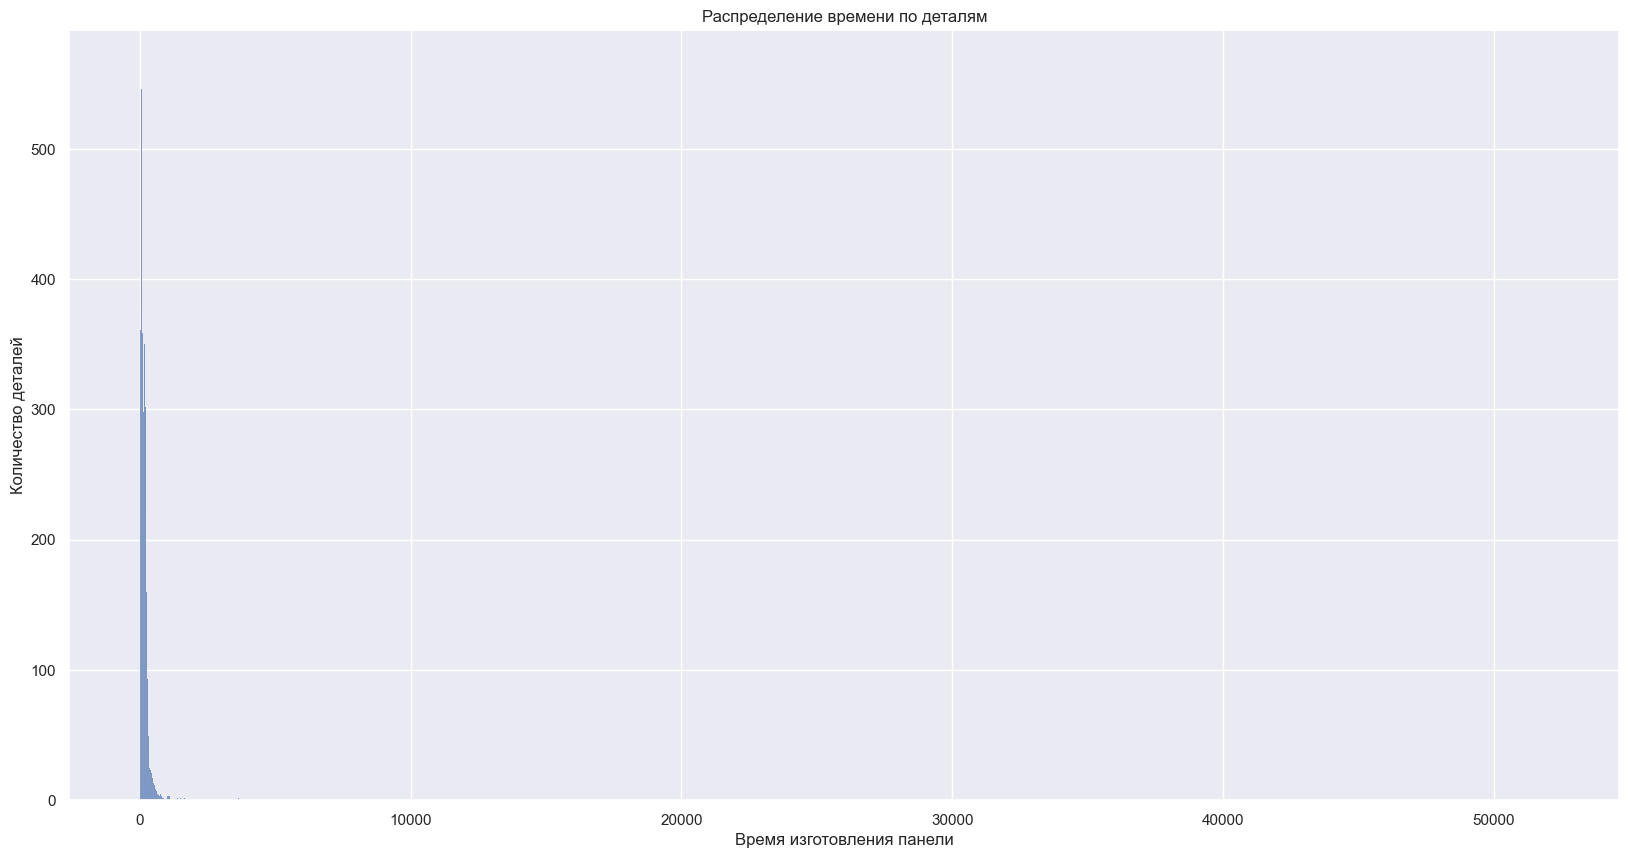

In [617]:
ax = sns.histplot(df.time)
ax.set_title('Распределение времени по деталям')
ax.set_ylabel('Количество деталей')
ax.set_xlabel('Время изготовления панели')

Пролгарифмируем время.

In [618]:
df.time = df.time.apply(lambda x: np.log(x+1))

Очистим данные от выбросов, которые нашлись после логарифмирования

In [619]:
_, df = outliers_z_score_mod(df, 'time')

In [620]:
_.shape

(55, 61)

In [621]:
df.shape

(6619, 61)

Проверим распределение на нормальность после всех преобразований

Text(0.5, 0, 'Логарифм времени изготовления')

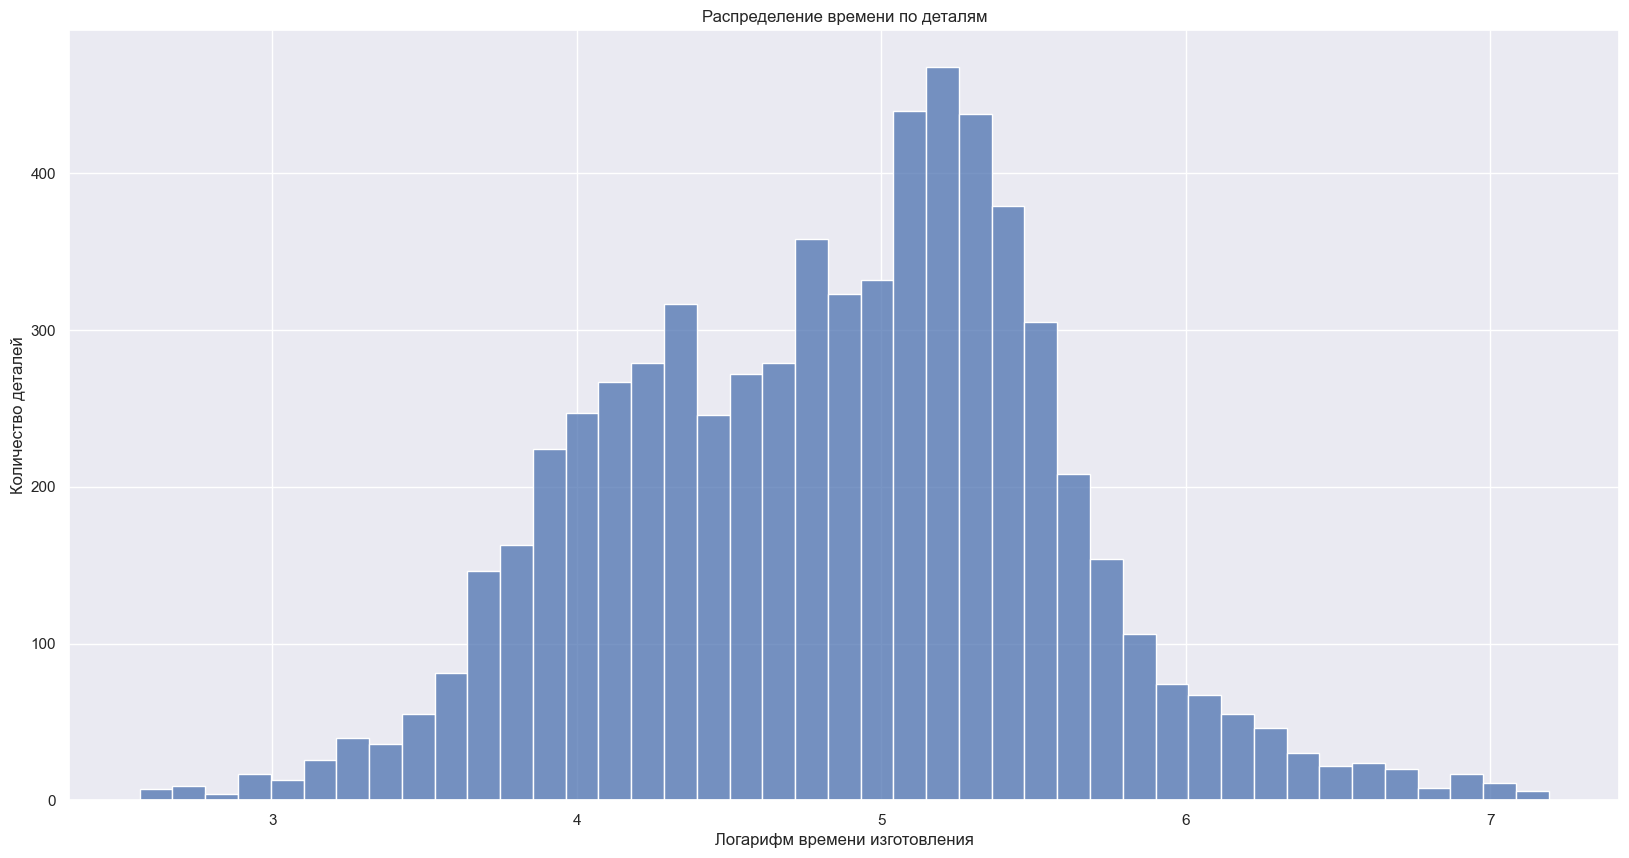

In [622]:
ax = sns.histplot(df.time)
ax.set_title('Распределение времени по деталям')
ax.set_ylabel('Количество деталей')
ax.set_xlabel('Логарифм времени изготовления')

In [623]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

Установим уровень значимости

In [624]:
alpha = 0.05

In [625]:
_, p = normaltest(df.time.to_numpy())
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.519
Данные распределены нормально


***Вывод:*** мы имеем дело с распределением не являющимся нормальным.

## Посмотрим некоторые зависимости в данных.

Предположительно, ключевыми для времени будут зависимости от конфигурации панели и от количества отверстий. Попробуем построить визуальные отображение этих зависимостей и посмотреть на них.

Text(0.5, 0, 'Логарифм времени изготовления')

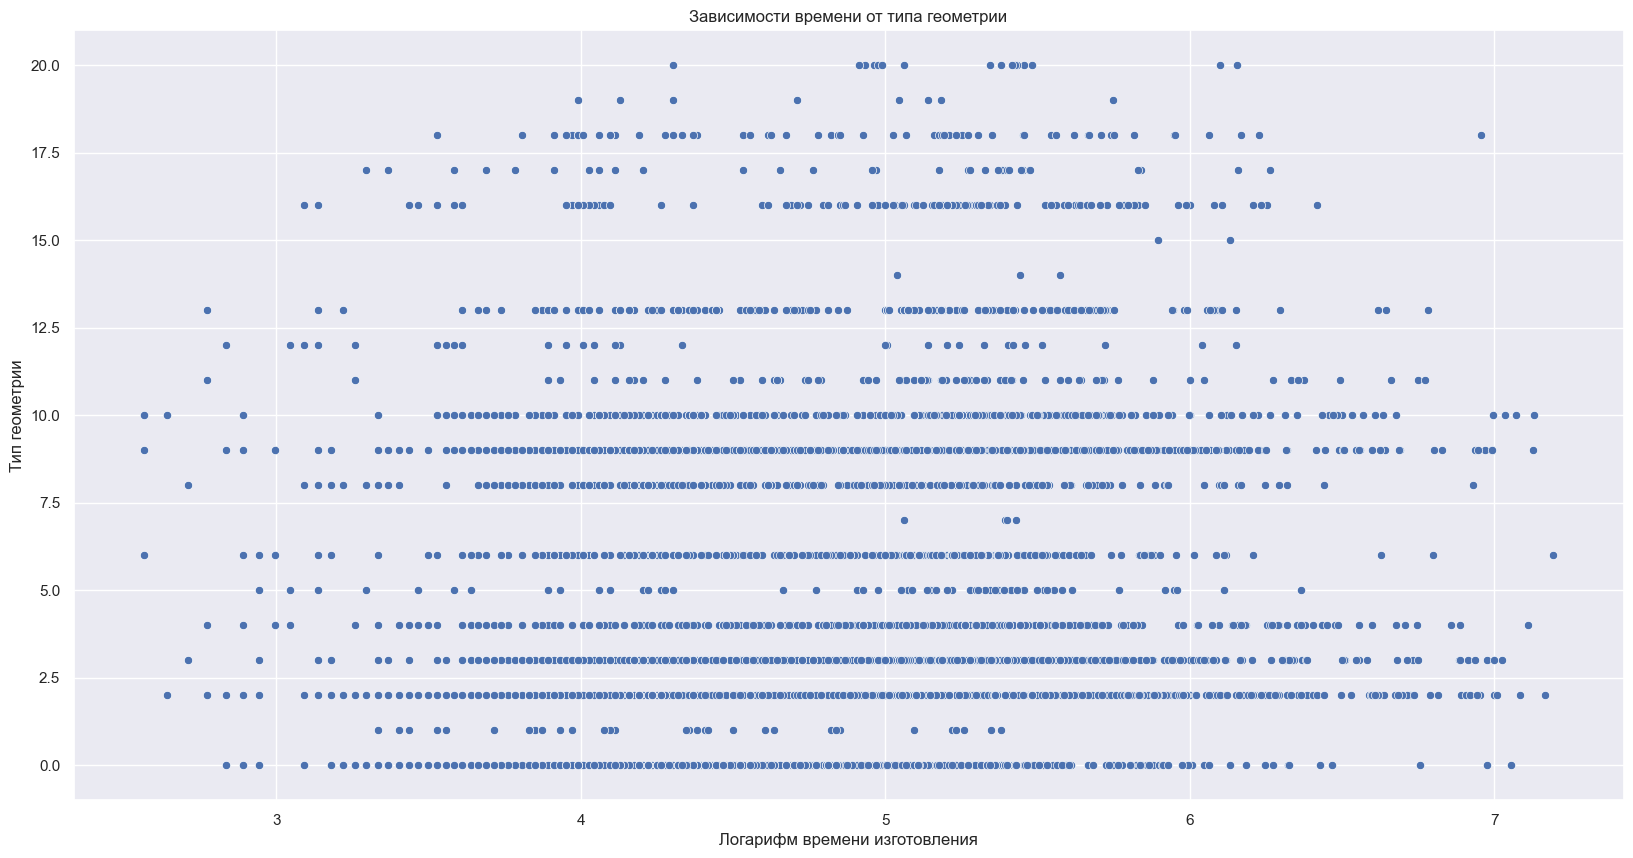

In [626]:
ax = sns.scatterplot(x=df.time, y=df.part_goemID)
ax.set_title('Зависимости времени от типа геометрии')
ax.set_ylabel('Тип геометрии')
ax.set_xlabel('Логарифм времени изготовления')

***Вывод:*** из визуализации видно, что зависимость присутствует, но не ялвяется ярко выраженной.

Попробуем построить более детальную картину, где учтем влияние геометрических размеров, типа геометрии и количества отверстий.

In [627]:
fig = px.scatter_3d(x=df.part_length, y=df.part_width, z=df.time, color=df.part_goemID, size=df.HolesUnique)

fig.update_layout(
    autosize=False,
    width=1200,
    height=1200,
)

fig.show()

***Вывод:*** хорошо видно, что прослеживается сложная зависимость между геометрическими размерами, типом геометрии и количеством уникальных отверстий. По всей видимости, зависимость не носит линейный характер, поэтому для ее отражения лучше всего подойдут нелинейные методы.

Построим тепловую картку кореляционных коэффициентов. Посмотри на зависимости признаков по отношению ко времени.

<AxesSubplot:>

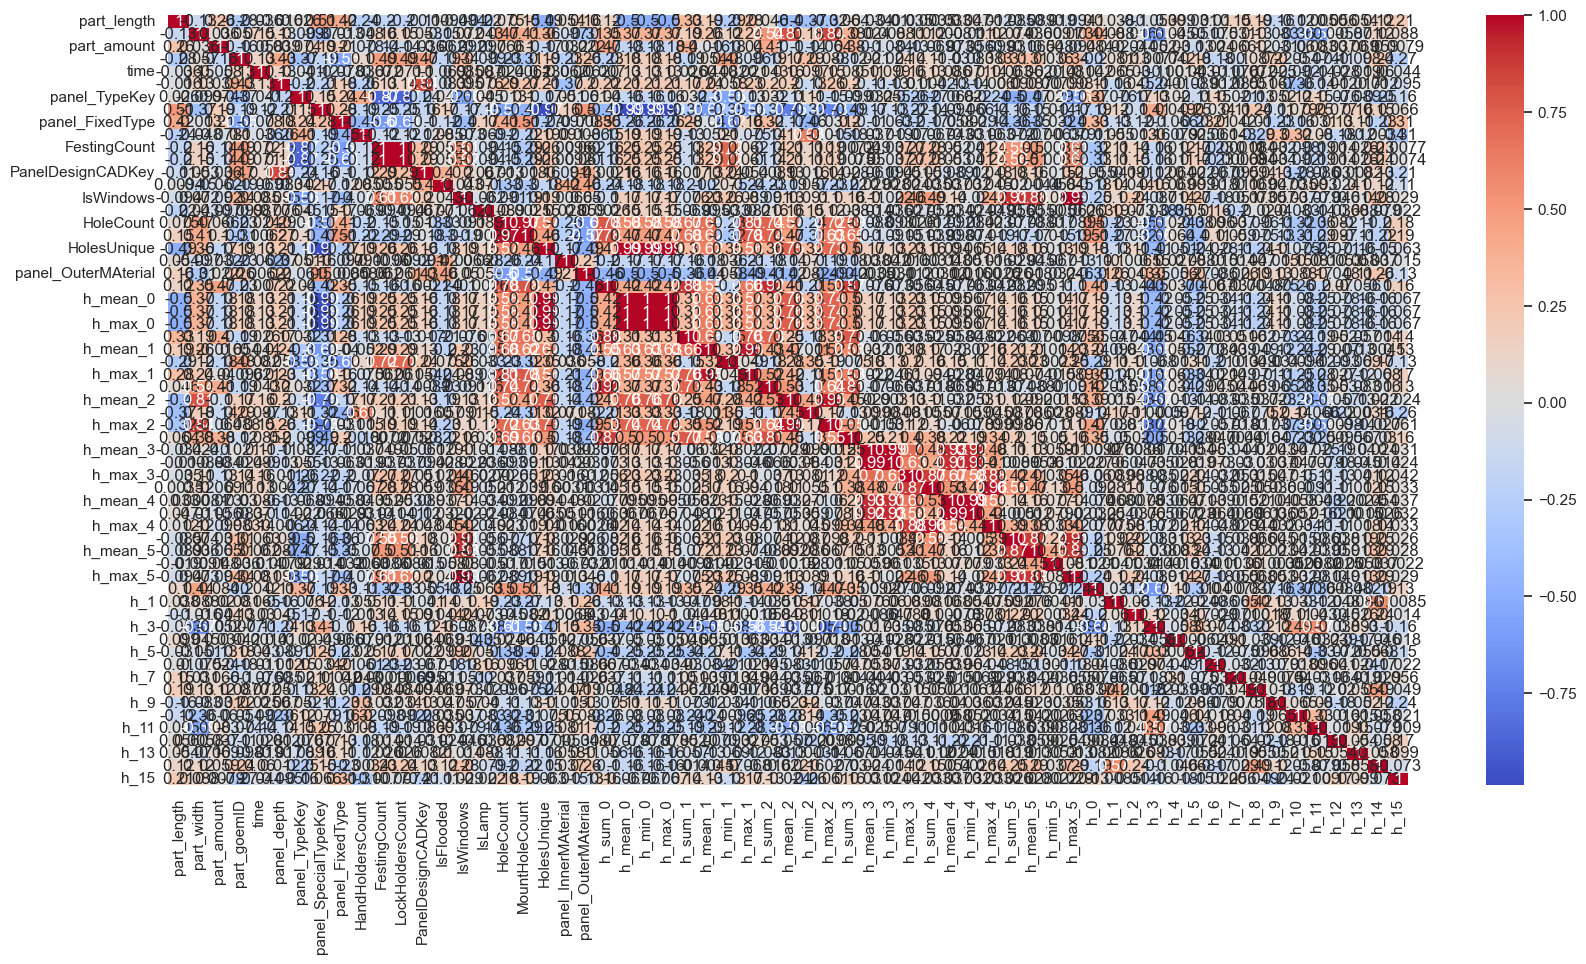

In [628]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Удалим признаки, имеющие мультиколлинеарность.

In [629]:
df.drop([
    'FestingCount', 'MountHoleCount' ,'panel_SpecialTypeKey','h_mean_0',
    'h_max_0','h_min_0','h_max_1','h_mean_3','h_mean_3','h_mean_3',
    'h_min_4','h_max_4','h_sum_4','h_max_5'
        ], axis=1, inplace=True)

C:\Users\saakyan.ag\AppData\Local\Temp\ipykernel_11832\4246058185.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Убедимся в отсутствии мультиколлинеарности.

<AxesSubplot:>

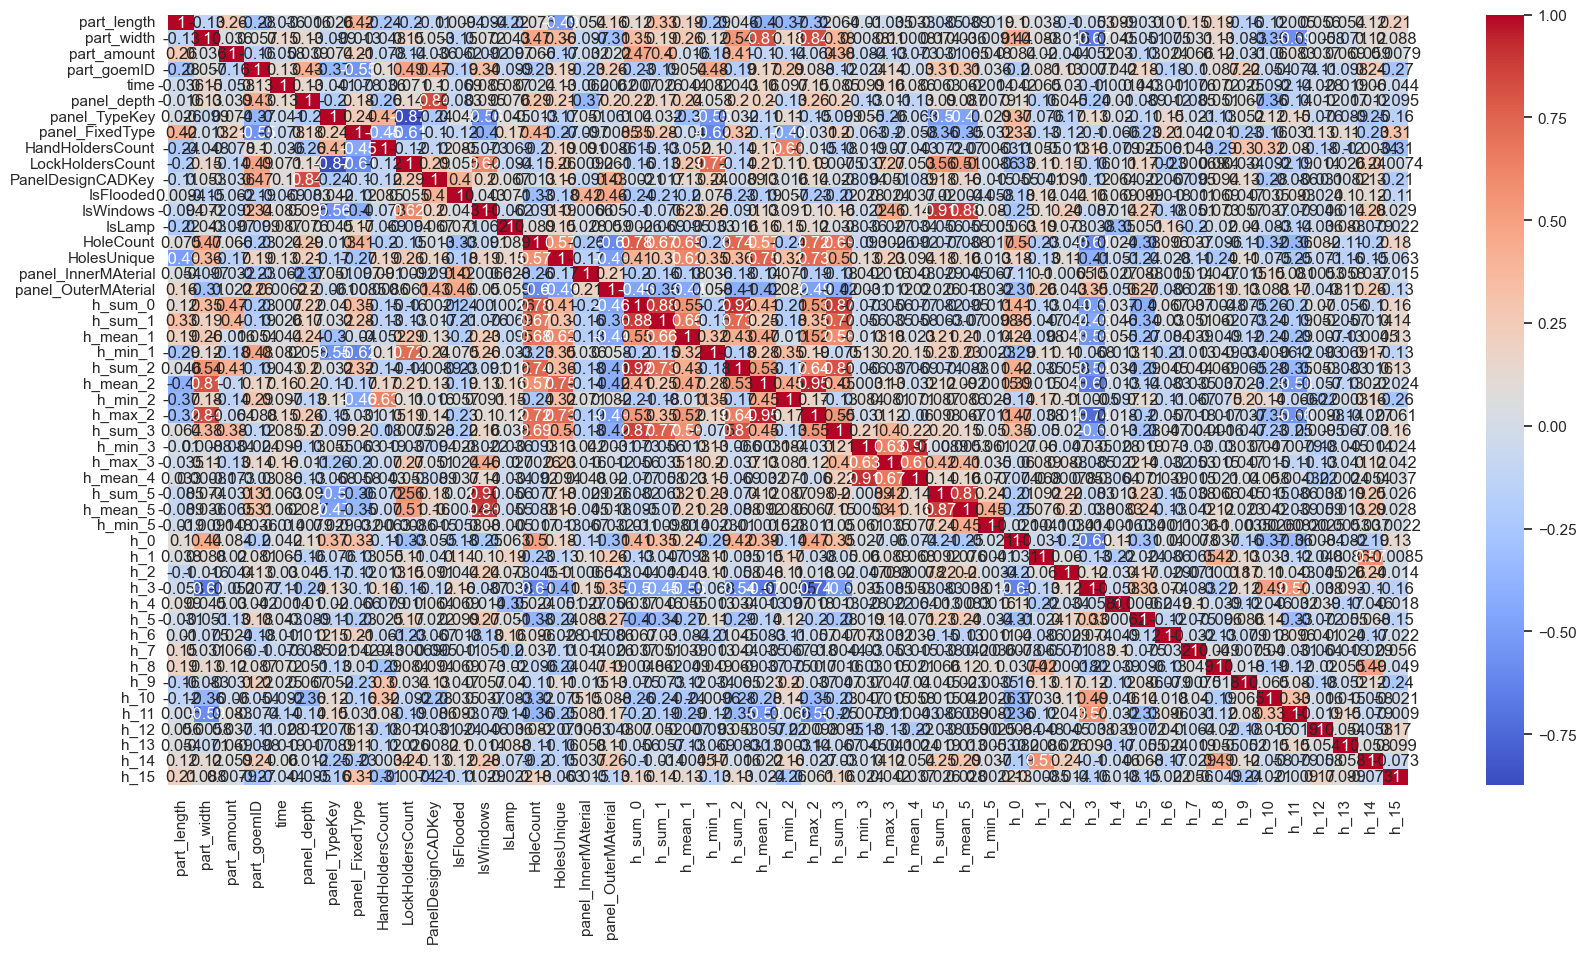

In [630]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

***Вывод:*** мултиколленеарности устранены, можно переходить к построению моделей.

# Обучение моделей

Разобьем данные на признаки и ответы. И разделим данные для валидации на тестовые и тренировочные

In [631]:
RAND_STATE = 42

In [632]:
y = df['time'].copy()
X = df.drop(['time'], axis=1)

In [674]:
X

part_length  part_width  part_amount  part_goemID  panel_depth  \
0        0.401348    0.504274            1            4            1   
1        0.401798    0.948718            1            4            1   
2        0.403596    0.799145            1           13            1   
3        0.404494    0.487179            2            2            1   
4        0.404494    0.029060            1            6            1   
...           ...         ...          ...          ...          ...   
6669     0.400000    0.363248            1            2            1   
6670     0.400000    0.363248            1            2            1   
6671     0.400000    0.363248            2            3            1   
6672     0.400000    0.378205            1            2            1   
6673     0.400899    0.504274            1            4            1   

      panel_TypeKey  panel_FixedType  HandHoldersCount  LockHoldersCount  \
0                 2                2                 0                 0   
1                 2                2                 0                 0   
2                 3                0                 2                 0   
3                 2                2                 0                 0   
4                 2                2                 0                 0   
...             ...              ...               ...               ...   
6669              2                2                 0                 0   
6670              2                2                 0                 0   
6671              2                2                 0                 0   
6672              2                2                 0                 0   
6673              2                2                 0                 0   

      PanelDesignCADKey  IsFlooded  IsWindows  IsLamp  HoleCount  HolesUnique  \
0                     2          0          0       0   0.680851            1   
1                     2          0          0       0   0.957447            1   
2                     6          1          0       0   0.085106            1   
3                     5          1          0       0   0.680851            1   
4                     5          1          0       0   0.063830            1   
...                 ...        ...        ...     ...        ...          ...   
6669                  5          1          0       0   0.680851            1   
6670                  5          1          0       0   0.680851            1   
6671                  5          1          0       0   0.000000            0   
6672                  5          1          0       0   0.680851            1   
6673                  2          0          0       0   0.680851            1   

      panel_InnerMAterial  panel_OuterMAterial   h_sum_0   h_sum_1  h_mean_1  \
0                       2                    0  0.100000  0.074223  0.428816   
1                       2                    0  0.140625  0.102390  0.420659   
2                       5                    3  0.012500  0.009324  0.430961   
3                       3                    1  0.200000  0.149484  0.431818   
4                       5                    3  0.009375  0.001795  0.110635   
...                   ...                  ...       ...       ...       ...   
6669                    3                    1  0.100000  0.074000  0.427530   
6670                    3                    1  0.100000  0.074000  0.427530   
6671                    3                    3  0.000000  0.000000  0.000000   
6672                    3                    1  0.100000  0.074000  0.427530   
6673                    2                    0  0.100000  0.074148  0.428388   

       h_min_1   h_sum_2  h_mean_2   h_min_2   h_max_2   h_sum_3   h_min_3  \
0     0.012042  0.079635  0.320149  0.005473  0.523810  0.082759  0.003448   
1     0.012042  0.198228  0.566699  0.005473  0.950739  0.424138  0.003448   
2     0.101806  0.020388  0.655721  0.628109  0.563834  0.01

In [675]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619 entries, 0 to 6673
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   part_length          6619 non-null   float64
 1   part_width           6619 non-null   float64
 2   part_amount          6619 non-null   int64  
 3   part_goemID          6619 non-null   int32  
 4   panel_depth          6619 non-null   int32  
 5   panel_TypeKey        6619 non-null   int32  
 6   panel_FixedType      6619 non-null   int32  
 7   HandHoldersCount     6619 non-null   int64  
 8   LockHoldersCount     6619 non-null   int64  
 9   PanelDesignCADKey    6619 non-null   int32  
 10  IsFlooded            6619 non-null   int32  
 11  IsWindows            6619 non-null   int32  
 12  IsLamp               6619 non-null   int32  
 13  HoleCount            6619 non-null   float64
 14  HolesUnique          6619 non-null   int64  
 15  panel_InnerMAterial  6619 non-null   i

Отбросим 10% на валидацию.

In [633]:
X_tr, X_valid, y_tr, y_valid = model_selection.train_test_split(X, y, test_size=0.1, random_state=RAND_STATE)

In [634]:
X_tr.shape, X_valid.shape

((5957, 48), (662, 48))

Разобьем оставшиеся данные на тренировочные и тостевые.

In [635]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_tr, y_tr, test_size=0.2, random_state=RAND_STATE)

X_train.shape, X_test.shape

((4765, 48), (1192, 48))

## Базовая модель

Для базовой модели возьмем обычную модель линейной регрессии. 

In [636]:
lin_mod = linear_model.LinearRegression()

Обучим модель и сделаем предсказание.

In [637]:
lin_mod.fit(X_train, y_train)

y_lin_tr_pred = lin_mod.predict(X_train)
y_lin_te_pred = lin_mod.predict(X_test)

In [638]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_lin_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_lin_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.44
MAE на тестовой части: 0.45


In [639]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_lin_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_lin_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.11
MAPE на тестовой части: 0.11


***Вывод:*** базовая модель уже довольно хорошо предсказывает время. А значит, более сложные модели могут дать еще прирост точности.

### Попробуем обучить модель на полиномиальных признаках.

In [640]:
%%time
poly_2 = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

poly_2.fit(X_train, y_train)

y_pl_tr_pred = poly_2.predict(X_train)
y_pl_te_pred = poly_2.predict(X_test)

CPU times: total: 5.8 s
Wall time: 2.09 s


In [641]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_pl_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_pl_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.32
MAE на тестовой части: 0.48


In [642]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_pl_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_pl_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.09
MAPE на тестовой части: 0.37


In [643]:
%%time
poly_3 = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])

poly_3.fit(X_train, y_train)

y_pl_tr_pred = poly_3.predict(X_train)
y_pl_te_pred = poly_3.predict(X_test)

CPU times: total: 4min 33s
Wall time: 1min 27s


In [644]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_pl_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_pl_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.20
MAE на тестовой части: 0.62


In [645]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_pl_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_pl_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.07
MAPE на тестовой части: 0.32


***Вывод:*** модель с полиномиальными признаками показывает переобучение и время обучения значительно увеличивается.

## Случайный лес

In [646]:
rf = ensemble.RandomForestRegressor(random_state=RAND_STATE)

In [647]:
rf.fit(X_train, y_train)

y_rf_tr_pred = rf.predict(X_train)
y_rf_te_pred = rf.predict(X_test)

In [648]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_rf_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_rf_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.21
MAE на тестовой части: 0.39


In [649]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_rf_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_rf_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.06
MAPE на тестовой части: 0.11


***Вывод:*** Данная модель уже показывает хороший результат на обучающей выборке. Вполне возможно, что есть шанс добиться еще более хороших результатов при подстройке макропараметров.

## Модель опорных векторов

In [650]:
svr = SVR()

In [651]:
svr.fit(X_train, y_train)

y_svr_tr_pred = svr.predict(X_train)
y_svr_te_pred = svr.predict(X_test)

In [652]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_svr_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_svr_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.42
MAE на тестовой части: 0.44


In [653]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_svr_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_svr_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.11
MAPE на тестовой части: 0.11


***Вывод:*** модель показывает похожий результат с линейной регрессий.

## Catboost

In [654]:
cb = CatBoostRegressor()
cb.fit(X_train, y_train)

y_cb_tr_pred = cb.predict(X_train)
y_cb_te_pred = cb.predict(X_test)

Learning rate set to 0.051534
0:	learn: 0.7284238	total: 10ms	remaining: 10s
1:	learn: 0.7250066	total: 17.3ms	remaining: 8.64s
2:	learn: 0.7219650	total: 24.4ms	remaining: 8.1s
3:	learn: 0.7180087	total: 32.3ms	remaining: 8.05s
4:	learn: 0.7146420	total: 40.1ms	remaining: 7.98s
5:	learn: 0.7108532	total: 48ms	remaining: 7.96s
6:	learn: 0.7087223	total: 56.6ms	remaining: 8.03s
7:	learn: 0.7063620	total: 65ms	remaining: 8.06s
8:	learn: 0.7042849	total: 71.9ms	remaining: 7.91s
9:	learn: 0.7017414	total: 79.1ms	remaining: 7.83s
10:	learn: 0.6991120	total: 85.8ms	remaining: 7.72s
11:	learn: 0.6972040	total: 92.4ms	remaining: 7.61s
12:	learn: 0.6949858	total: 98.5ms	remaining: 7.48s
13:	learn: 0.6929979	total: 107ms	remaining: 7.53s
14:	learn: 0.6913887	total: 113ms	remaining: 7.45s
15:	learn: 0.6893767	total: 121ms	remaining: 7.45s
16:	learn: 0.6880193	total: 128ms	remaining: 7.42s
17:	learn: 0.6866480	total: 135ms	remaining: 7.38s
18:	learn: 0.6851732	total: 141ms	remaining: 7.3s
19:	lear

In [655]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_cb_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_cb_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.31
MAE на тестовой части: 0.39


In [656]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_cb_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_cb_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.08
MAPE на тестовой части: 0.10


In [657]:
y_hat_real_tr = np.exp(y_cb_tr_pred)-1
y_real_tr = np.exp(y_train)-1


print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_hat_real_tr, y_real_tr):.2f}',
      f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_hat_real_tr, y_real_tr):.2f}', sep='\n')

MAE на тренировочной части: 36.19
MAPE на тренировочной части: 0.46


In [658]:
y_hat_real_te = np.exp(y_cb_te_pred)-1
y_real_te = np.exp(y_test)-1


print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_hat_real_te, y_real_te):.2f}',
      f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_hat_real_te, y_real_te):.2f}', sep='\n')

MAE на тренировочной части: 44.78
MAPE на тренировочной части: 0.58


<AxesSubplot:title={'center':'Значимость признаков'}, xlabel='Уровень значимости', ylabel='Название признака'>

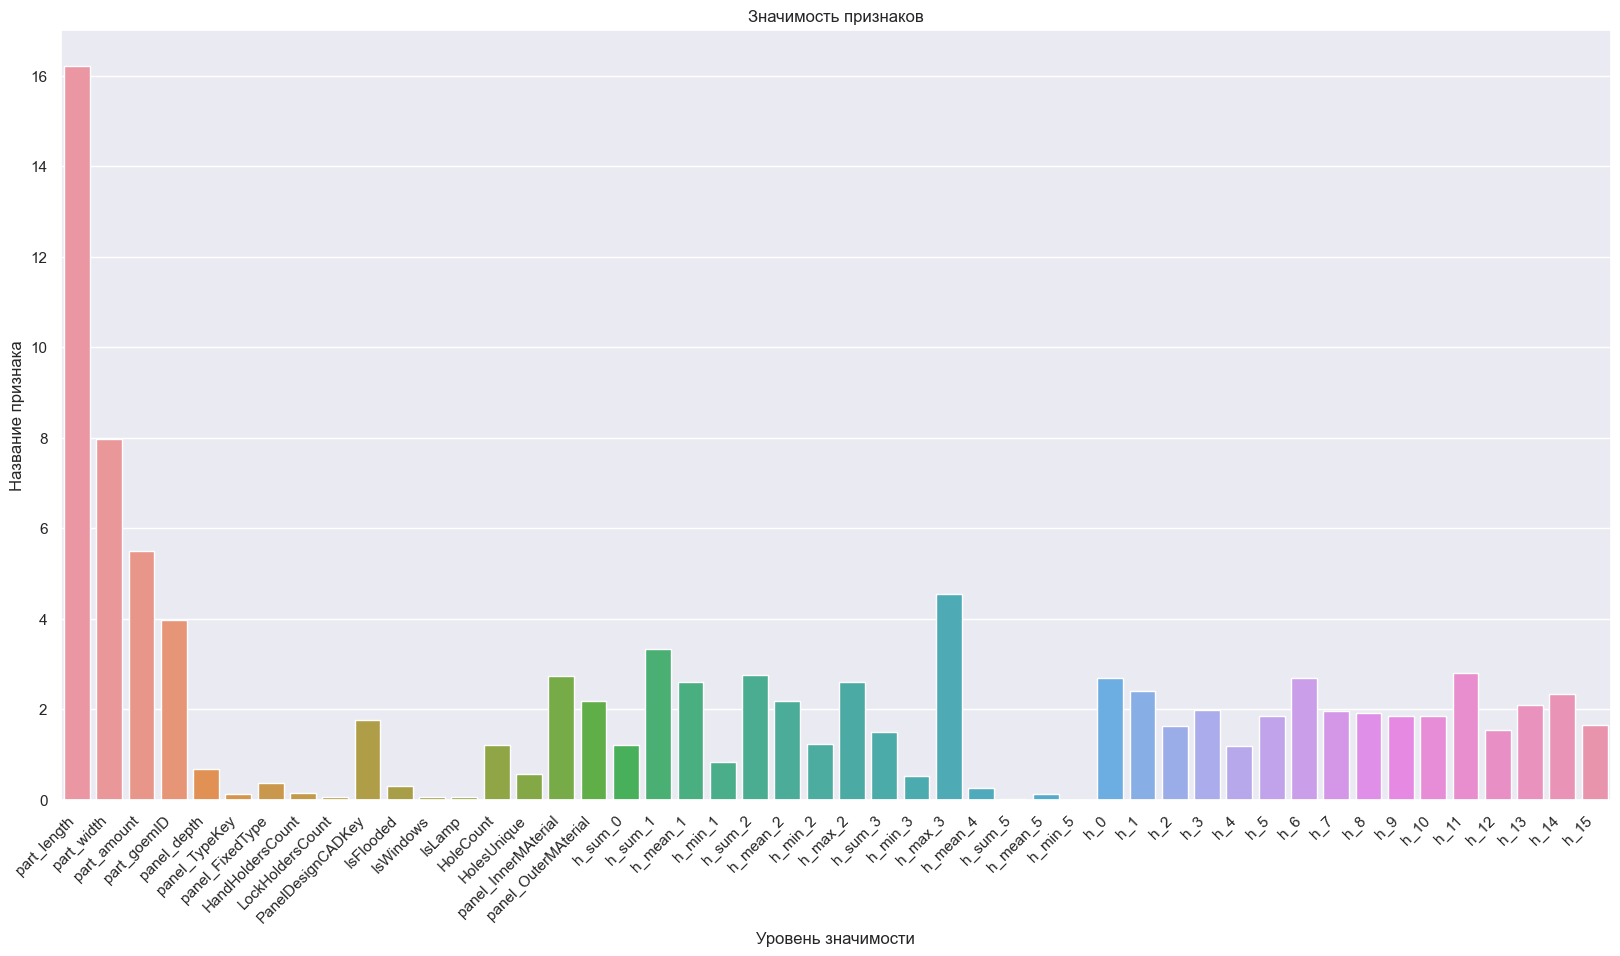

In [659]:
ax = sns.barplot(x=X.columns, y=cb.feature_importances_)
ax.set_title('Значимость признаков')
ax.set_ylabel('Название признака')
ax.set_xlabel('Уровень значимости')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax

## Тюнинг моделей

### Случайный лес

In [660]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 5)
    max_depth = trial.suggest_int('max_depth', 10, 50, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, 1)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])

    # создаем модель
    model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            max_features=max_features,
                                            random_state=RAND_STATE,
                                            n_jobs=-1
                                            )
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.mean_absolute_percentage_error( model.predict(X_train), y_train)

    return score

In [661]:
study_rf = optuna.create_study(study_name="RandomForestRegression", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials 60 раз
study_rf.optimize(optuna_rf, n_trials=60)

[I 2023-01-24 13:42:03,101] A new study created in memory with name: RandomForestRegression
[I 2023-01-24 13:42:04,233] Trial 0 finished with value: 0.08955121100964097 and parameters: {'n_estimators': 345, 'max_depth': 28, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.08955121100964097.
[I 2023-01-24 13:42:04,915] Trial 1 finished with value: 0.09461500003628702 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.08955121100964097.
[I 2023-01-24 13:42:06,330] Trial 2 finished with value: 0.10122446210502727 and parameters: {'n_estimators': 455, 'max_depth': 10, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.08955121100964097.
[I 2023-01-24 13:42:06,998] Trial 3 finished with value: 0.09849849470772391 and parameters: {'n_estimators': 205, 'max_depth': 40, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 0 with value: 0.089551211

In [662]:
rf_best = ensemble.RandomForestRegressor(random_state=RAND_STATE, **study_rf.best_params)

In [663]:
rf_best.fit(X_train, y_train)

y_rf_tr_pred = rf_best.predict(X_train)
y_rf_te_pred = rf_best.predict(X_test)


In [664]:
print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_train, y_rf_tr_pred):.2f}',
      f'MAE на тестовой части: {metrics.median_absolute_error(y_test, y_rf_te_pred):.2f}', sep='\n')

MAE на тренировочной части: 0.27
MAE на тестовой части: 0.38


In [665]:
print(f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_rf_tr_pred, y_train):.2f}',
      f'MAPE на тестовой части: {metrics.mean_absolute_percentage_error(y_rf_te_pred, y_test):.2f}', sep='\n')

MAPE на тренировочной части: 0.08
MAPE на тестовой части: 0.10


In [666]:
y_hat_real_tr = np.exp(y_rf_tr_pred)-1
y_real_tr = np.exp(y_train)-1


print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_hat_real_tr, y_real_tr):.2f}',
      f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_hat_real_tr, y_real_tr):.2f}', sep='\n')

MAE на тренировочной части: 31.23
MAPE на тренировочной части: 0.41


In [667]:
y_hat_real_te = np.exp(y_rf_te_pred)-1
y_real_te = np.exp(y_test)-1


print(f'MAE на тренировочной части: {metrics.median_absolute_error(y_hat_real_te, y_real_te):.2f}',
      f'MAPE на тренировочной части: {metrics.mean_absolute_percentage_error(y_hat_real_te, y_real_te):.2f}', sep='\n')

MAE на тренировочной части: 46.24
MAPE на тренировочной части: 0.57


Посмотрим на признаки, влияющие на результат модели.

<AxesSubplot:title={'center':'Значимость признаков'}, xlabel='Уровень значимости', ylabel='Название признака'>

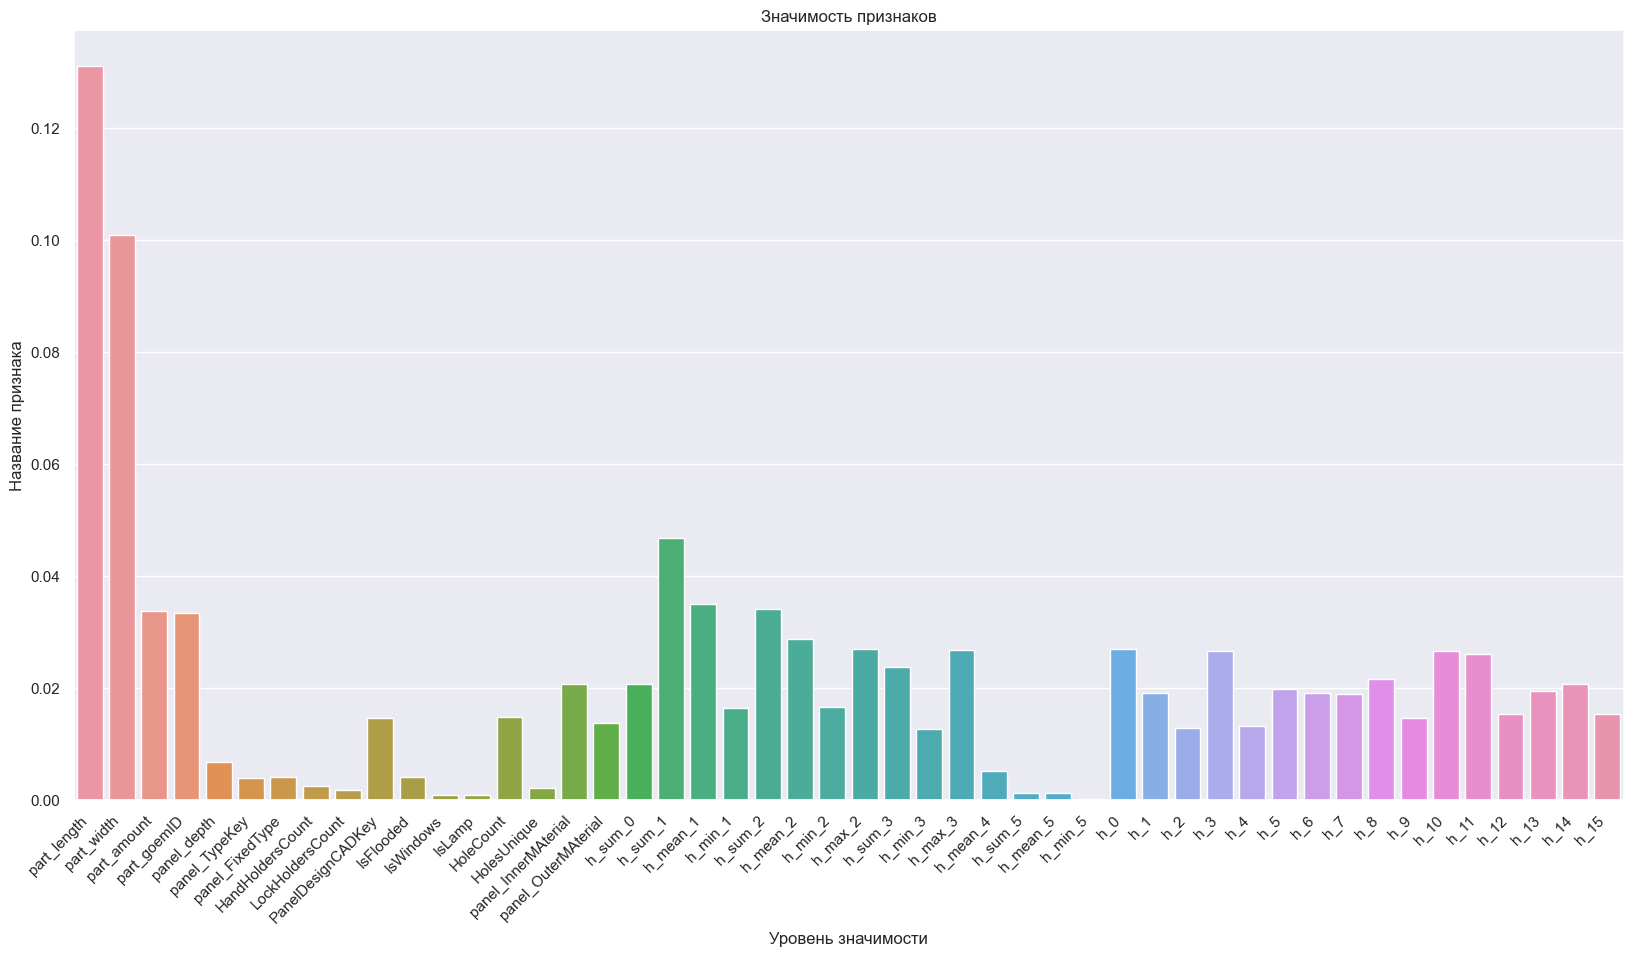

In [668]:
ax = sns.barplot(x=rf_best.feature_names_in_, y=rf_best.feature_importances_)
ax.set_title('Значимость признаков')
ax.set_ylabel('Название признака')
ax.set_xlabel('Уровень значимости')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax

# Выводы

В условиях отсутствия какой-либо оценки загрузки линии, полученная точность модели может вполне подойти. Более того, в разрезе заказа (состоящего из нескольких десятков панелей) и разрезе набранного объема заказов на день такая разница может быть еще более усреднена. То есть ошибка при оценке загрузки может быть меньше, либо иметь выраженную тенденцию к завышению или занижению загрузки, что в дальнейшем можно нивелировать коэффициентом.

Кроме того, с накоплением большего количества данных, можно будет переобучить модель и получить более точные данные для оценки.

В будущем при накоплении большего количества данных можно сделать кластеризацию данных и для каждого кластера построить свою регрессионную модель, что должно повысить точность предсказания.

# Посмотрим на валидацию

In [669]:
y_rf_val_pred = rf_best.predict(X_valid)

In [670]:
print(f'MAE на валидационной части: {metrics.median_absolute_error(y_valid, y_rf_val_pred):.2f}',
      f'MAPE на валидационной части: {metrics.mean_absolute_percentage_error(y_rf_val_pred, y_valid):.2f}', sep='\n')

MAE на валидационной части: 0.37
MAPE на валидационной части: 0.10


In [671]:
y_hat_real_val = np.exp(y_rf_val_pred)-1
y_real_val = np.exp(y_valid)-1

print(f'MAE на валидационной части: {metrics.median_absolute_error(y_hat_real_val, y_real_val):.2f}',
      f'MAPE на валидационной части: {metrics.mean_absolute_percentage_error(y_hat_real_val, y_real_val):.2f}', sep='\n')

MAE на валидационной части: 42.71
MAPE на валидационной части: 0.55


***Выводы:*** Результаты валидации находятся в том же диапозоне, что и тренировки и теста.

# Сохраним обученную модель и инструменты преобразования данных с помощью pickle. И приступим к реализации сервиса для предсказания времени загрузки.

Сохраним обученные процессоры:

In [672]:
with open('data_processors.pkl', 'wb') as tmp_file:
    pickle.dump(data_processors, tmp_file)

Сохраним модель:

In [673]:
with open('model.pkl', 'wb') as tmp_file:
    pickle.dump(rf_best, tmp_file)